# Is Warren Buffet's Portfolio Choice Optimal?

## 1. Introduction

Warren Buffet is the world's most prominent value investor. We decided to analyze his portfolio to see if there were any improvements to be made. We make use of the work of:
- Michael Pinelis and David Ruppert (Machine learning portfolio allocation(2021))
-  Shihao Gu, Bryan Kelly, and Dacheng Xiu (Empirical Asset Pricing via Machine
 Learning(2019))

In [1]:
%pip install missingno
%pip install xgboost
%pip install tensorflow 
%pip install keras
%pip install ortools


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached protobuf-4.25.3-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
Using cached protobuf-4.25.3-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.27.2
    Uninstalling protobuf-5.27.2:
      Successfully uninstalled protobuf-5.27.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ortools 9.10.4067 requires protobuf>=5.26.1, but you have protobuf 4.25.3 which is incompatible.
streamlit 1.17.0 requires protobuf<4,>=3.12, bu

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno 
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel
import base64
from IPython.display import Image, display
from sklearn.model_selection import RandomizedSearchCV

## 2. Research Method

In [3]:
def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
graph TD
    subgraph "Data Processing"
        A[Raw Data] --> B[Missing Value Imputation]
        B --> C[Normalization]
    end

    subgraph "Feature Engineering"
        D[Features] --> E[Fundamental Features]
        D --> F[Technical Features]
        D --> G[Sentiment Features]
    end
    
    E --> H[RF Model Training]
    F --> H
    G --> H
		
    subgraph "Training"
        H[RF Model Training] --> I[Hyperparameter Optimization]
        I --> J[Optimal Model]
    end

    subgraph "Prediction"
        K[Test Data] --> L[Return Ratio Prediction]
    end

    subgraph "Investment Strategy"
        M[Investment Strategy] --> N[Stock Selection]
        N --> O[Investment Portfolio Return & Std]
    end

    subgraph "Evaluation"
        P[Evaluation Method] --> Q[Sharpe Ratio]
    end

    C --> D
    J --> L
    L --> N
    O --> Q
""")

## 3.1 Data Processing

## Financial Data

In [4]:
BuffetPortfolioOverview = pd.read_csv("Warren Buffet Portfolio Overview.csv")
BuffetPortfolioOverview

,Company,Ticker,"Market value as of 31 March, 2024",Number of shares,% of total portfolio
0,APPLE INC (COM),AAPL,"135,360,902,000","789,368,450",40.81%
1,BANK OF AMERICA CORP (COM),BAC,"39,165,748,000","1,032,852,006",11.81%
2,AMERICAN EXPRESS CO (COM),AXP,"34,520,240,000","151,610,700",10.41%
3,COCA COLA CO (COM),KO,"24,472,000,000","400,000,000",7.38%
4,CHEVRON CORP (COM),CVX,"19,398,898,000","122,980,207",5.85%
5,OCCIDENTAL PETROLEUM (COM),OXY,"16,118,698,000","248,018,128",4.86%
6,KRAFT HEINZ CO (COM),KHC,"12,015,925,000","325,634,818",3.62%
7,MOODYS CORP (COM),MCO,"9,695,962,000","24,669,778",2.92%
8,CHUBB LIMITED (COM),CB,"6,717,645,000","25,923,840",2.03%
9,DAVITA HEALTHCARE PARTNERS (COM),DVA,"4,982,993,000","36,095,570",1.50%


In [5]:
# Load the CSV file to examine its content
fin_data = pd.read_csv('2014-2024 Buffet Portfolio - financial ratios.csv')
fin_data.head()
fin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4711 entries, 0 to 4710
Data columns (total 76 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gvkey            4711 non-null   int64  
 1   permno           4711 non-null   int64  
 2   adate            4701 non-null   object 
 3   qdate            4711 non-null   object 
 4   public_date      4711 non-null   object 
 5   CAPEI            4642 non-null   float64
 6   bm               4397 non-null   float64
 7   evm              4701 non-null   float64
 8   pe_op_basic      4640 non-null   float64
 9   pe_op_dil        4640 non-null   float64
 10  pe_exi           4640 non-null   float64
 11  pe_inc           4640 non-null   float64
 12  ps               4701 non-null   float64
 13  pcf              4680 non-null   float64
 14  dpr              4234 non-null   float64
 15  npm              4701 non-null   float64
 16  opmbd            4701 non-null   float64
 17  opmad         

In [6]:
# Converting 'public_date' into datetime type
fin_data['public_date'] = pd.to_datetime(fin_data['public_date'])

# Dropping unnecessary columns
columns_to_drop = ['gvkey', 'permno', 'adate', 'qdate', 'cusip']
fin_data = fin_data.drop(columns=columns_to_drop)

# Displaying the first few rows of the cleaned data
fin_data.head()

,public_date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,...,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,TICKER
0,2010-01-31,23.091,0.202,12.573,9.688,9.688,10.046,10.046,4.107,15.381,...,1.388,15.193,0.0,0.094,0.0,-0.042,5.013,1.519,3.02%,KO
1,2010-02-28,21.273,0.201,14.863,17.342,17.457,17.993,17.993,3.921,14.846,...,1.250,8.091,0.0,0.090,0.0,-0.031,4.607,1.609,3.11%,KO
2,2010-03-31,22.193,0.201,14.863,18.092,18.212,18.771,18.771,4.091,15.488,...,1.250,8.091,0.0,0.090,0.0,-0.031,4.806,1.679,3.20%,KO
3,2010-04-30,21.585,0.201,14.863,17.582,17.699,18.242,18.242,3.979,15.064,...,1.250,8.091,0.0,0.090,0.0,-0.031,4.675,1.632,3.29%,KO
4,2010-05-31,20.947,0.208,13.336,7.957,8.082,8.454,8.454,3.783,13.726,...,1.297,9.058,0.0,0.090,0.0,-0.033,4.500,0.708,3.42%,KO


In [7]:
fin_data.describe()

,public_date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,...,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing
count,4711,4642.000000,4397.000000,4701.000000,4640.000000,4640.000000,4640.000000,4640.000000,4701.000000,4680.000000,...,4521.000000,4696.000000,4375.000000,2479.000000,4701.000000,4701.000000,4701.000000,4680.000000,4397.000000,3051.000000
mean,2017-02-12 13:14:07.463383552,29.878632,0.603942,12.443296,12.870193,13.309260,16.051649,17.033933,3.696466,13.681471,...,8.888087,1.292531,3.418766,14.165560,0.015078,0.020006,0.071173,-0.041818,5.523823,1.640502
min,2010-01-31 00:00:00,-2615.300000,0.003000,-4544.900000,-714.520000,-714.520000,-2125.000000,-2125.000000,0.062000,-614.440000,...,-0.233000,0.113000,0.120000,-172.250000,0.000000,0.000000,0.000000,-0.267000,0.222000,-77.522000
25%,2013-07-31 00:00:00,11.699750,0.199000,9.098000,9.100500,9.259250,8.402750,8.348750,1.190000,5.610750,...,1.741000,0.383000,0.672500,2.986500,0.000000,0.000000,0.000000,-0.071000,1.076000,0.188000
50%,2017-02-28 00:00:00,20.942000,0.466000,12.573000,15.622500,15.936000,16.173500,15.949500,1.888000,10.781000,...,4.070000,0.715000,1.396000,6.415000,0.000000,0.006000,0.000000,-0.036000,2.175000,0.616000
75%,2020-08-31 00:00:00,35.358500,0.928000,17.987000,24.894000,25.753750,27.509250,27.724250,3.906000,19.852000,...,10.905000,1.235250,2.573000,12.497000,0.004000,0.032000,0.148000,-0.012000,5.232000,1.449000
max,2023-12-31 00:00:00,1447.000000,3.614000,1223.880000,478.000000,490.500000,758.328000,774.000000,126.556000,400.801000,...,77.108000,44.562000,152.413000,977.032000,0.465000,0.204000,0.905000,0.757000,64.657000,63.498000
std,NaN,137.151234,0.508289,127.622422,53.446141,53.375605,82.607543,82.795749,6.762963,34.117325,...,12.296629,2.200181,9.041726,43.464448,0.044623,0.028905,0.124070,0.058970,9.266644,5.971164


In [8]:
fin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4711 entries, 0 to 4710
Data columns (total 71 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   public_date      4711 non-null   datetime64[ns]
 1   CAPEI            4642 non-null   float64       
 2   bm               4397 non-null   float64       
 3   evm              4701 non-null   float64       
 4   pe_op_basic      4640 non-null   float64       
 5   pe_op_dil        4640 non-null   float64       
 6   pe_exi           4640 non-null   float64       
 7   pe_inc           4640 non-null   float64       
 8   ps               4701 non-null   float64       
 9   pcf              4680 non-null   float64       
 10  dpr              4234 non-null   float64       
 11  npm              4701 non-null   float64       
 12  opmbd            4701 non-null   float64       
 13  opmad            4701 non-null   float64       
 14  gpm              4701 non-null   float64

In [9]:
fin_data.isnull().sum() 

public_date        0
CAPEI             69
bm               314
evm               10
pe_op_basic       71
                ... 
accrual           31
ptb              314
PEG_trailing    1660
divyield        1756
TICKER            12
Length: 71, dtype: int64

In [10]:
# Identify columns that may contain percentage signs or non-numeric values
for col in fin_data.columns:
    if fin_data[col].dtype == 'object':
        # Check if there's a percentage sign and convert
        try:
            fin_data[col] = fin_data[col].str.replace('%', '').astype(float) / 100
        except Exception as e:
            print(f"Issue with column {col}: {e}")

Issue with column TICKER: could not convert string to float: 'KO'


In [11]:
fin_data['TICKER'].value_counts()

TICKER
KO       168
AAPL     168
CVX      168
V        168
SIRI     168
BAC      168
AXP      168
LPX      168
MCO      168
OXY      168
KR       168
COF      168
DVA      168
AMZN     168
VRSN     168
MA       168
NVR      168
C        168
CHTR     158
TMUS     125
CBS      121
ALLY     113
ITG      110
ES       104
LUK      103
JEF      103
KHC       98
FND       77
SNOW      76
CB        72
FWONK     70
LSXMK     70
NU        64
BYI       59
PCS       43
AON       28
VIAC      27
PARA      20
LSXMA     19
CHP       11
LLYVK      2
AOC        1
MXM        1
Name: count, dtype: int64

In [12]:
fin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4711 entries, 0 to 4710
Data columns (total 71 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   public_date      4711 non-null   datetime64[ns]
 1   CAPEI            4642 non-null   float64       
 2   bm               4397 non-null   float64       
 3   evm              4701 non-null   float64       
 4   pe_op_basic      4640 non-null   float64       
 5   pe_op_dil        4640 non-null   float64       
 6   pe_exi           4640 non-null   float64       
 7   pe_inc           4640 non-null   float64       
 8   ps               4701 non-null   float64       
 9   pcf              4680 non-null   float64       
 10  dpr              4234 non-null   float64       
 11  npm              4701 non-null   float64       
 12  opmbd            4701 non-null   float64       
 13  opmad            4701 non-null   float64       
 14  gpm              4701 non-null   float64

## Missing Data

CAPEI             69
bm               314
evm               10
pe_op_basic       71
pe_op_dil         71
                ... 
accrual           31
ptb              314
PEG_trailing    1660
divyield        1756
TICKER            12
Length: 70, dtype: int64
Missing value ratios:
cash_conversion    0.512842
sale_nwc           0.473785
divyield           0.372745
PEG_trailing       0.352367
inv_turn           0.296328
                     ...   
opmad              0.002123
opmbd              0.002123
ptpm               0.002123
gpm                0.002123
cfm                0.002123
Length: 70, dtype: float64


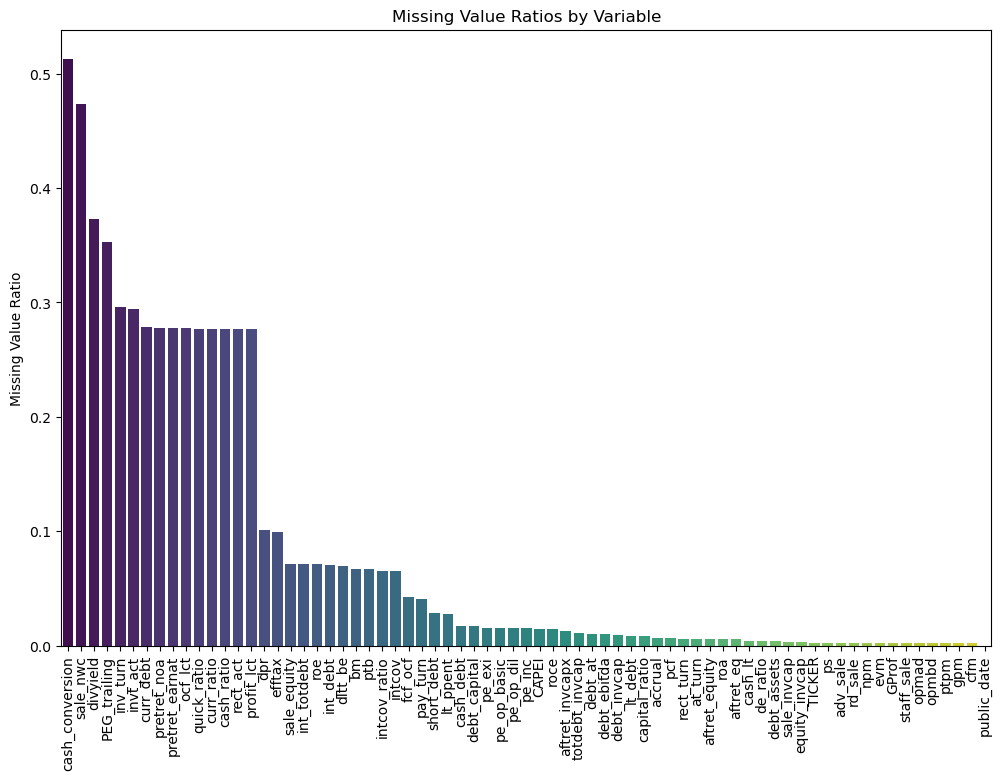

<Figure size 1200x800 with 0 Axes>

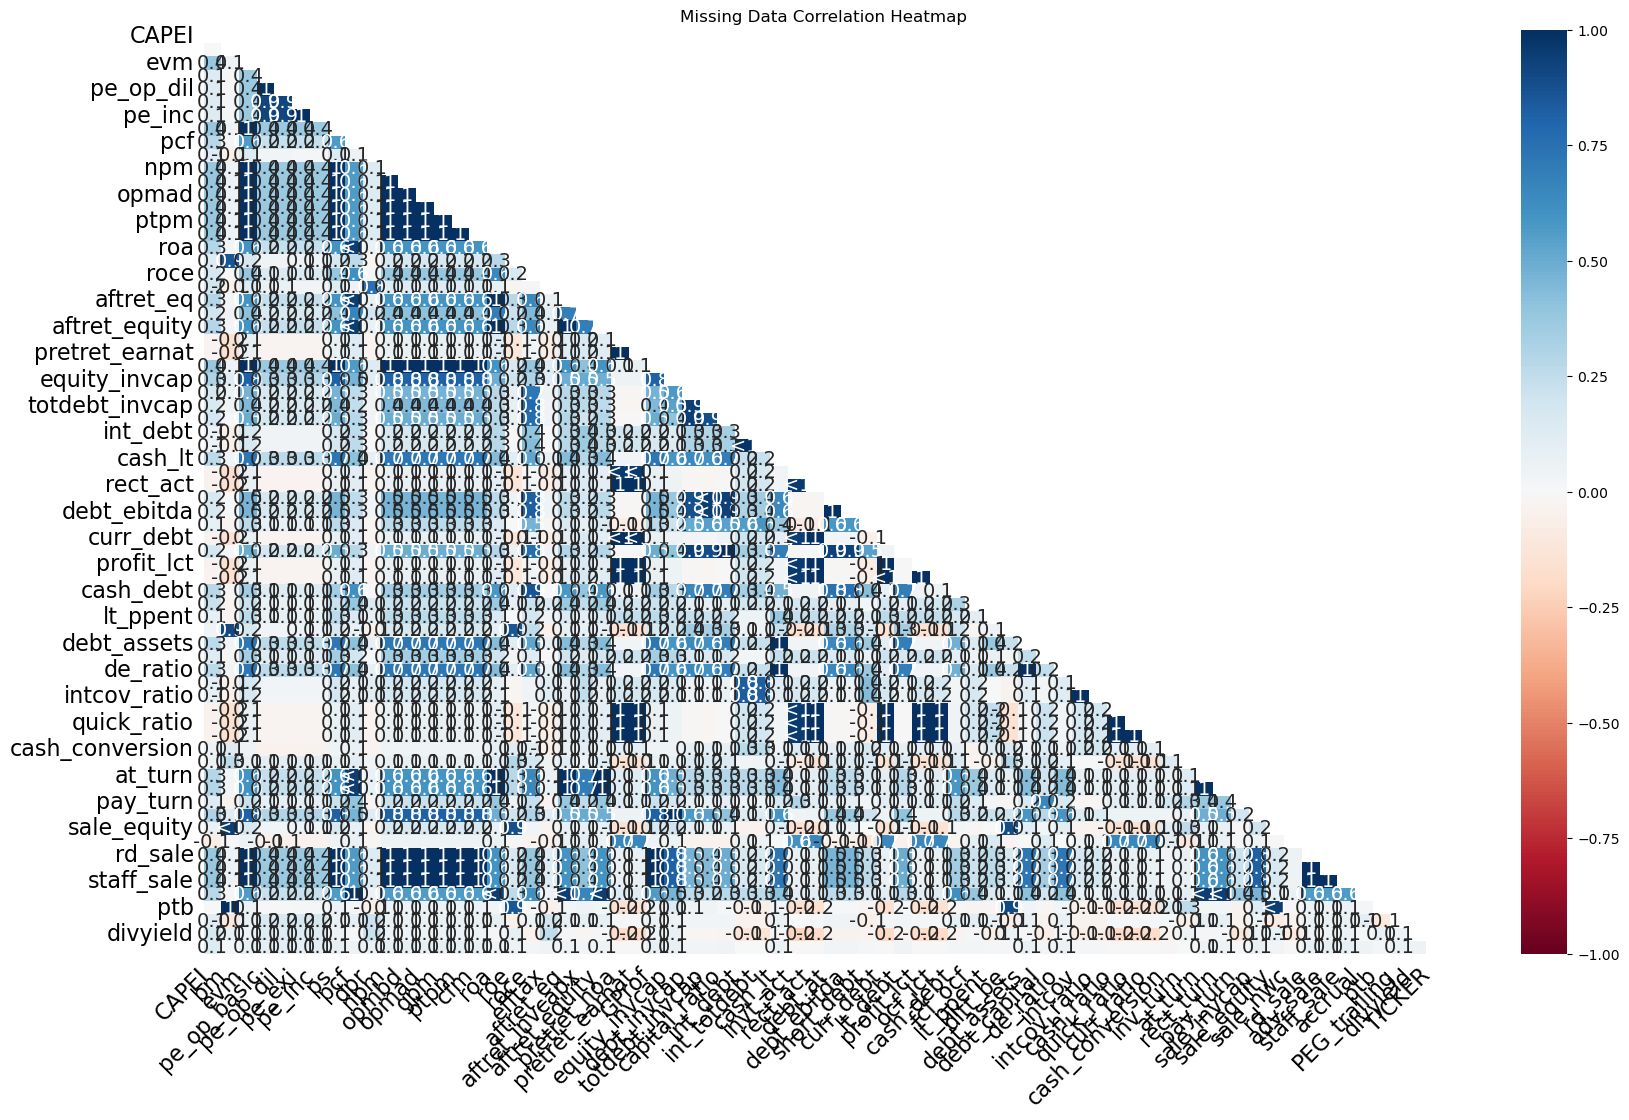

In [13]:
# Check the missing in the data
missing_values = fin_data.isnull().sum()
print(missing_values[missing_values > 0])

# Calculate the missing value ratio for each variable
missing_ratios = fin_data.isnull().mean().sort_values(ascending=False)
print("Missing value ratios:")
print(missing_ratios[missing_ratios > 0])  # Only show variables with missing values

# Visualize the missing value ratios using a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=missing_ratios.index, y=missing_ratios, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel('Missing Value Ratio')
plt.title('Missing Value Ratios by Variable')
plt.show()

# Visualize the correlation of missing data
plt.figure(figsize=(12, 8))
msno.heatmap(fin_data)
plt.title('Missing Data Correlation Heatmap')
plt.show()


In [14]:
# Ensure data is sorted by date
fin_data = fin_data.sort_index()

# 1. Handling high missing rate group
high_missing_cols = ['cash_conversion', 'sale_nwc']

for col in high_missing_cols:
    # Fill using the median of a time window
    fin_data[col] = fin_data[col].fillna(fin_data[col].rolling(window=30, min_periods=1, center=True).median())
    # For missing values at the start and end, use the global median
    fin_data[col] = fin_data[col].fillna(fin_data[col].median())

# Assume missing values in 'divyield' are 0 (company does not pay dividends)
fin_data['divyield'] = fin_data['divyield'].fillna(0)

# 2. Handling medium missing rate group
med_missing_cols = ['invt_act', 'inv_turn', 'curr_ratio', 'quick_ratio', 'cash_ratio', 
                    'ocf_lct', 'profit_lct', 'curr_debt', 'pretret_earnat', 'pretret_noa', 'rect_act',
                    'PEG_trailing']

for col in med_missing_cols:
    # First, perform forward fill
    fin_data[col] = fin_data[col].fillna(method='ffill', limit=5)
    # Then fill using the median of a time window
    fin_data[col] = fin_data[col].fillna(fin_data[col].rolling(window=30, min_periods=1, center=True).median())
    # For remaining missing values, use the global median
    fin_data[col] = fin_data[col].fillna(fin_data[col].median())

# 3. Handling low missing rate group
low_missing_cols = ['sale_equity', 'int_totdebt', 'int_debt', 'intcov_ratio', 'ptb', 'bm']

for col in low_missing_cols:
    # Use forward fill, then backward fill
    fin_data[col] = fin_data[col].fillna(method='ffill').fillna(method='bfill')

# 4. Handling very low missing rate group
very_low_missing_cols = ['debt_ebitda', 'pe_inc', 'pe_op_dil', 'pe_op_basic', 'pe_exi']

for col in very_low_missing_cols:
    # Use simple linear interpolation
    fin_data[col] = fin_data[col].interpolate()


# 5. Use MICE method for remaining numeric variables
numeric_columns = fin_data.select_dtypes(include=[np.number]).columns.tolist()

mice_imputer = IterativeImputer(max_iter=20, random_state=0)
fin_data_mice = pd.DataFrame(mice_imputer.fit_transform(fin_data[numeric_columns]), 
                             columns=numeric_columns, index=fin_data.index)
fin_data.update(fin_data_mice)

# 6. Handle any remaining missing values
non_numeric_columns = fin_data.select_dtypes(exclude=[np.number]).columns.tolist()
mode_imputer = SimpleImputer(strategy='most_frequent')
fin_data[non_numeric_columns] = mode_imputer.fit_transform(fin_data[non_numeric_columns])

# 7. Check if there are any remaining missing values
remaining_missing = fin_data.isnull().sum()
print("Remaining missing values:\n", remaining_missing[remaining_missing > 0])

print("Data preparation completed.")


/tmp/ipykernel_80953/1826159988.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fin_data[col] = fin_data[col].fillna(method='ffill', limit=5)
/tmp/ipykernel_80953/1826159988.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fin_data[col] = fin_data[col].fillna(method='ffill', limit=5)
/tmp/ipykernel_80953/1826159988.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fin_data[col] = fin_data[col].fillna(method='ffill', limit=5)
/tmp/ipykernel_80953/1826159988.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fin_data[col] = fin_data[col].fillna(method='ffill', limit=5)
/tmp/ipykernel_80953/1826159988.py:23: FutureWarning: Se

Remaining missing values:
 Series([], dtype: int64)
Data preparation completed.


## Stock Data

In [15]:
# Load the CSV file to examine its content
sto_data = pd.read_csv('2014-2024 Buffet Portfolio - stock.csv')
sto_data.head()
sto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89589 entries, 0 to 89588
Data columns (total 63 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PERMNO    89589 non-null  int64  
 1   date      89589 non-null  object 
 2   NAMEENDT  127 non-null    object 
 3   SHRCD     89589 non-null  int64  
 4   EXCHCD    89589 non-null  int64  
 5   SICCD     89589 non-null  object 
 6   NCUSIP    89589 non-null  object 
 7   TICKER    89589 non-null  object 
 8   COMNAM    89589 non-null  object 
 9   SHRCLS    24210 non-null  object 
 10  TSYMBOL   89589 non-null  object 
 11  NAICS     89563 non-null  float64
 12  PRIMEXCH  89589 non-null  object 
 13  TRDSTAT   89589 non-null  object 
 14  SECSTAT   89589 non-null  object 
 15  PERMCO    89589 non-null  int64  
 16  ISSUNO    89589 non-null  int64  
 17  HEXCD     89589 non-null  int64  
 18  HSICCD    89589 non-null  int64  
 19  CUSIP     89589 non-null  object 
 20  DCLRDT    931 non-null    ob

/tmp/ipykernel_80953/2734722974.py:2: DtypeWarning: Columns (5,9,22,49,57) have mixed types. Specify dtype option on import or set low_memory=False.
  sto_data = pd.read_csv('2014-2024 Buffet Portfolio - stock.csv')


In [16]:
sto_data_selected = sto_data.copy()

In [17]:
# Converting 'public_date' into datetime type
sto_data_selected['date'] = pd.to_datetime(sto_data_selected['date'])

In [18]:
# Step 1: Handle the dependent variable (Return on Investment)
def clean_ret(ret):
    if isinstance(ret, str):
        # Handle special cases like 'C' or 'B'
        if ret in ['C', 'B']:
            return np.nan
        # Remove percentage sign and convert to float
        return float(ret.strip('%')) / 100
    return ret

# Convert the 'RET' column to numeric type
sto_data_selected['RET'] = sto_data_selected['RET'].apply(clean_ret)

In [19]:
# Step 3: Select relevant features
relevant_features = ['date', 'TICKER', 'COMNAM', 'SHRCD', 'EXCHCD', 'SICCD', 
                     'PRC', 'VOL', 'RET', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC', 
                     'vwretd', 'ewretd', 'sprtrn']
sto_data_selected = sto_data_selected[relevant_features]

In [20]:
sto_data_selected.describe()

,date,SHRCD,EXCHCD,PRC,VOL,RET,SHROUT,BIDLO,ASKHI,OPENPRC,vwretd,ewretd,sprtrn
count,89589,89589.000000,89589.000000,89583.000000,8.958300e+04,89570.000000,8.958300e+04,89583.000000,89583.000000,89583.000000,89589.000000,89589.000000,89589.000000
mean,2019-02-02 13:14:31.459665664,15.129893,1.757973,227.601511,1.079223e+07,0.000257,1.314680e+06,224.950986,230.144809,227.541278,0.000449,0.000343,0.000439
min,2014-01-02 00:00:00,11.000000,1.000000,3.065000,4.099000e+03,-0.283530,3.179000e+03,2.980000,3.110000,3.050000,-0.118168,-0.107631,-0.119841
25%,2016-08-16 00:00:00,11.000000,1.000000,37.470000,9.286940e+05,-0.000243,1.845000e+05,36.990000,37.950000,37.475000,-0.003923,-0.004576,-0.003812
50%,2019-02-05 00:00:00,11.000000,1.000000,76.680000,2.602606e+06,0.000011,4.387400e+05,75.880300,77.420000,76.660000,0.000668,0.000709,0.000597
75%,2021-08-09 00:00:00,11.000000,3.000000,163.575005,7.792302e+06,0.000370,1.045085e+06,161.955000,165.174995,163.519995,0.005631,0.005748,0.005690
max,2023-12-29 00:00:00,73.000000,4.000000,7024.819820,5.072443e+08,0.422587,1.710254e+07,6997.910160,7075.000000,7028.500000,0.091556,0.082175,0.093828
std,NaN,14.497378,1.053536,635.967039,2.389194e+07,0.012422,2.443694e+06,627.836061,643.910272,635.758014,0.011025,0.010709,0.011170


In [21]:
sto_data_selected.columns

Index(['date', 'TICKER', 'COMNAM', 'SHRCD', 'EXCHCD', 'SICCD', 'PRC', 'VOL',
       'RET', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC', 'vwretd', 'ewretd',
       'sprtrn'],
      dtype='object')

In [22]:
sto_data_selected.isnull().sum() 

date        0
TICKER      0
COMNAM      0
SHRCD       0
EXCHCD      0
SICCD       0
PRC         6
VOL         6
RET        19
SHROUT      6
BIDLO       6
ASKHI       6
OPENPRC     6
vwretd      0
ewretd      0
sprtrn      0
dtype: int64

In [23]:
sto_data_selected.head()

,date,TICKER,COMNAM,SHRCD,EXCHCD,SICCD,PRC,VOL,RET,SHROUT,BIDLO,ASKHI,OPENPRC,vwretd,ewretd,sprtrn
0,2014-01-02,KO,COCA COLA CO,11,1,2086,40.66,12720200.0,-0.000157,4415923.0,40.51,41.2250,41.12,-0.008757,-0.004051,-0.008862
1,2014-01-03,KO,COCA COLA CO,11,1,2086,40.46,10403800.0,-0.000049,4415923.0,40.35,40.7300,40.68,0.000491,0.004096,-0.000333
2,2014-01-06,KO,COCA COLA CO,11,1,2086,40.27,11041200.0,-0.000047,4415923.0,40.16,40.5926,40.48,-0.003340,-0.001676,-0.002512
3,2014-01-07,KO,COCA COLA CO,11,1,2086,40.39,11879600.0,0.000030,4415923.0,40.29,40.7208,40.48,0.006090,0.006892,0.006082
4,2014-01-08,KO,COCA COLA CO,11,1,2086,39.94,15357500.0,-0.000111,4415923.0,39.83,40.4400,40.44,0.000155,0.000835,-0.000212


In [24]:
# 3. TICKER (object) - Keep as string, may need label encoding
sto_data_selected['TICKER'] = sto_data_selected['TICKER'].astype('category')

# 5. SHRCD (int64) - Convert to categorical
sto_data_selected['SHRCD'] = sto_data_selected['SHRCD'].astype('category')

# 6. EXCHCD (int64) - Convert to categorical
sto_data_selected['EXCHCD'] = sto_data_selected['EXCHCD'].astype('category')

# 7. SICCD (object) - Convert to categorical
sto_data_selected['SICCD'] = sto_data_selected['SICCD'].astype('category')

In [25]:
# Define a function to safely apply LabelEncoder
def safe_label_encode(series):
    # Convert all values to strings
    series = series.astype(str)
    le = LabelEncoder()
    return pd.Series(le.fit_transform(series), index=series.index)

# For categorical variables that may need machine learning, we use a safe encoding method
for col in ['TICKER', 'SHRCD', 'EXCHCD', 'SICCD']:
    # First, check if there are any missing values in the column
    if sto_data_selected[col].isnull().any():
        # If there are missing values, fill them first
        sto_data_selected[col] = sto_data_selected[col].fillna('Unknown')
    
    # Then apply safe label encoding
    sto_data_selected[col + '_encoded'] = safe_label_encode(sto_data_selected[col])
    
    # Convert the original column to categorical type
    sto_data_selected[col] = sto_data_selected[col].astype('category')

# Display the processed data types
print(sto_data_selected.dtypes)

date              datetime64[ns]
TICKER                  category
COMNAM                    object
SHRCD                   category
EXCHCD                  category
SICCD                   category
PRC                      float64
VOL                      float64
RET                      float64
SHROUT                   float64
BIDLO                    float64
ASKHI                    float64
OPENPRC                  float64
vwretd                   float64
ewretd                   float64
sprtrn                   float64
TICKER_encoded             int64
SHRCD_encoded              int64
EXCHCD_encoded             int64
SICCD_encoded              int64
dtype: object


In [26]:
sto_data_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89589 entries, 0 to 89588
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            89589 non-null  datetime64[ns]
 1   TICKER          89589 non-null  category      
 2   COMNAM          89589 non-null  object        
 3   SHRCD           89589 non-null  category      
 4   EXCHCD          89589 non-null  category      
 5   SICCD           89589 non-null  category      
 6   PRC             89583 non-null  float64       
 7   VOL             89583 non-null  float64       
 8   RET             89570 non-null  float64       
 9   SHROUT          89583 non-null  float64       
 10  BIDLO           89583 non-null  float64       
 11  ASKHI           89583 non-null  float64       
 12  OPENPRC         89583 non-null  float64       
 13  vwretd          89589 non-null  float64       
 14  ewretd          89589 non-null  float64       
 15  sp

## Missing Data

PRC         6
VOL         6
RET        19
SHROUT      6
BIDLO       6
ASKHI       6
OPENPRC     6
dtype: int64
Missing value ratios:
RET        0.000212
PRC        0.000067
VOL        0.000067
SHROUT     0.000067
BIDLO      0.000067
ASKHI      0.000067
OPENPRC    0.000067
dtype: float64


<Figure size 600x500 with 0 Axes>

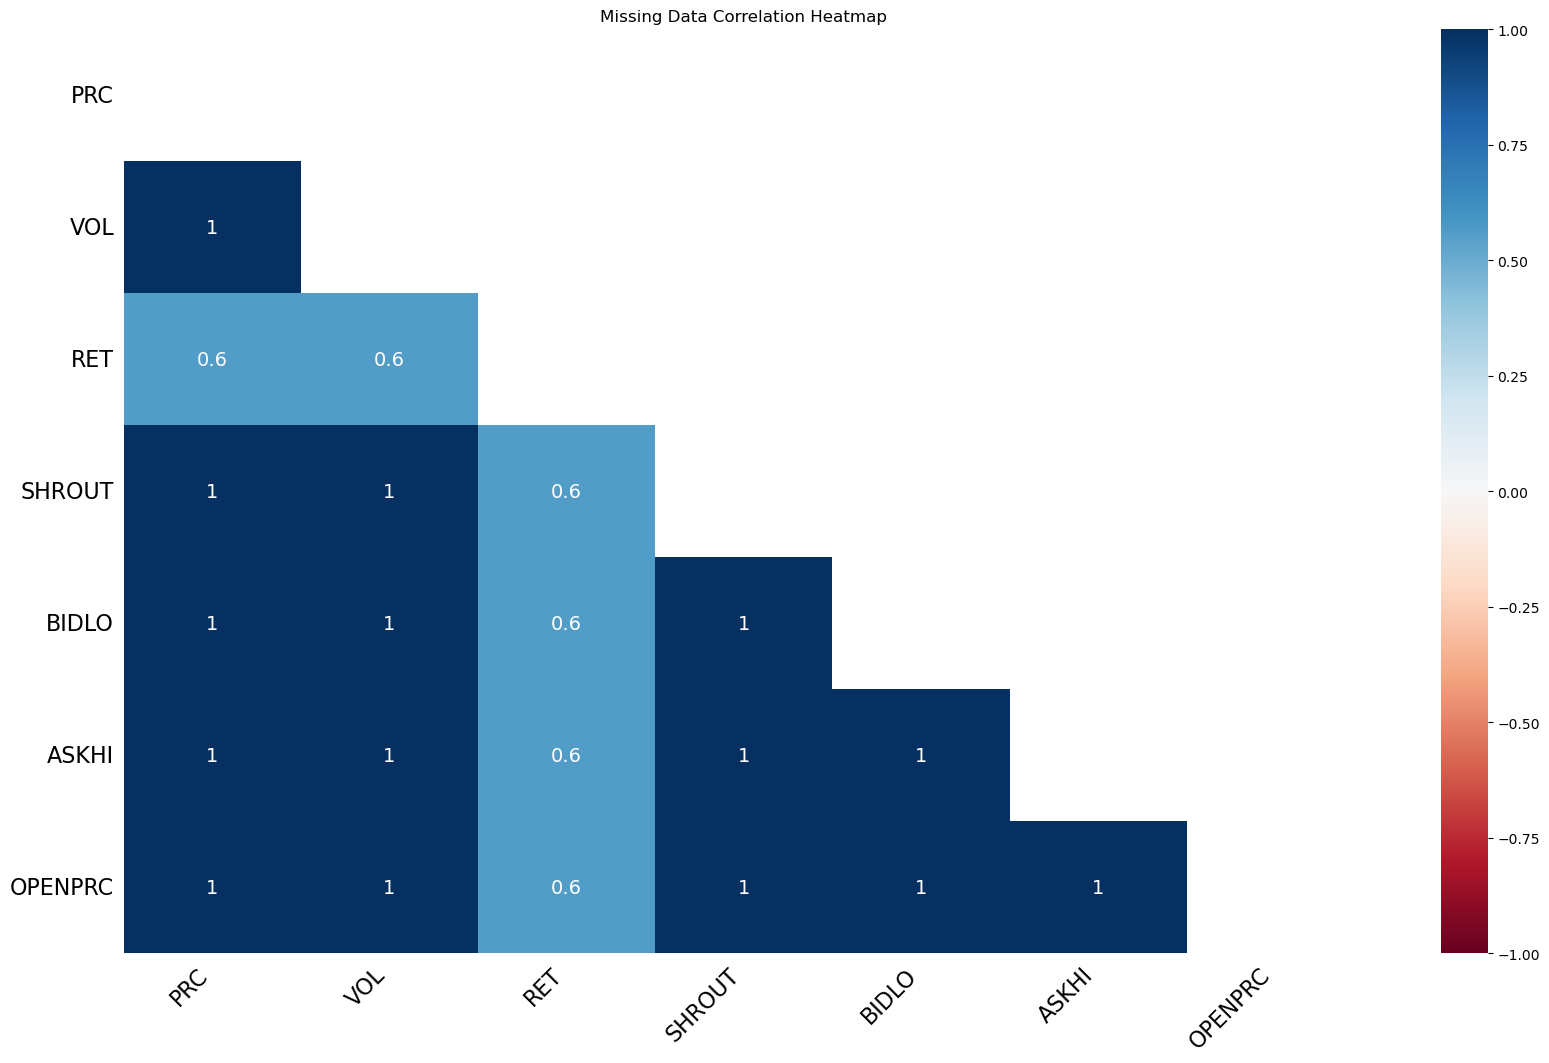

In [27]:
# Check the missing in the data
# Check for missing values in the data
missing_values = sto_data_selected.isnull().sum()
print(missing_values[missing_values > 0])

# Calculate the missing value ratio for each variable
missing_ratios = sto_data_selected.isnull().mean().sort_values(ascending=False)
print("Missing value ratios:")
print(missing_ratios[missing_ratios > 0])  # Only show variables with missing values

# Visualize the correlation of missing data
plt.figure(figsize=(6, 5))
msno.heatmap(sto_data_selected)
plt.title('Missing Data Correlation Heatmap')
plt.show()

In [28]:
# Ensure data is sorted by date
sto_data_selected = sto_data_selected.sort_values('date')

# Forward fill price-related data
price_columns = ['PRC', 'BIDLO', 'ASKHI', 'OPENPRC']
sto_data_selected[price_columns] = sto_data_selected.groupby('TICKER')[price_columns].fillna(method='ffill')

# Forward fill volume and shares outstanding
sto_data_selected[['VOL', 'SHROUT']] = sto_data_selected.groupby('TICKER')[['VOL', 'SHROUT']].fillna(method='ffill')

# Recalculate market capitalization
sto_data_selected['market_cap'] = sto_data_selected['PRC'].abs() * sto_data_selected['SHROUT']

# Check remaining missing values
missing_after = sto_data_selected[['PRC', 'VOL', 'RET', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC', 'market_cap']].isnull().sum()
print("Remaining missing values after processing:")
print(missing_after)


Remaining missing values after processing:
PRC            0
VOL            0
RET           19
SHROUT         0
BIDLO          0
ASKHI          0
OPENPRC        0
market_cap     0
dtype: int64


/tmp/ipykernel_80953/715366556.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sto_data_selected[price_columns] = sto_data_selected.groupby('TICKER')[price_columns].fillna(method='ffill')
/tmp/ipykernel_80953/715366556.py:6: FutureWarning: DataFrameGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use DataFrame.fillna instead
  sto_data_selected[price_columns] = sto_data_selected.groupby('TICKER')[price_columns].fillna(method='ffill')
/tmp/ipykernel_80953/715366556.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sto_data_selected[price_columns] = sto_data_selected.grou

In [29]:
sto_data_selected['RET'] = sto_data['RET'] 


In [30]:
# Handle return rate (RET)
# Method 1: Recalculate based on price if possible
sto_data_selected['RET_calc'] = sto_data_selected.groupby('TICKER', group_keys=False)['PRC'].pct_change()

# Method 2: Use linear interpolation on the original RET
sto_data_selected['RET_interp'] = sto_data_selected.groupby('TICKER', group_keys=False)['RET'].apply(lambda x: x.interpolate(method='linear'))

# Combine the results of both methods
sto_data_selected['RET'] = sto_data_selected['RET'].fillna(sto_data_selected['RET_calc'])
sto_data_selected['RET'] = sto_data_selected['RET'].fillna(sto_data_selected['RET_interp'])

/tmp/ipykernel_80953/601408475.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sto_data_selected['RET_calc'] = sto_data_selected.groupby('TICKER', group_keys=False)['PRC'].pct_change()
/tmp/ipykernel_80953/601408475.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sto_data_selected['RET_interp'] = sto_data_selected.groupby('TICKER', group_keys=False)['RET'].apply(lambda x: x.interpolate(method='linear'))
/tmp/ipykernel_80953/601408475.py:6: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instea

In [31]:
missing_after = sto_data_selected[['PRC', 'VOL', 'RET', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC', 'market_cap']].isnull().sum()
print("Remaining missing values after processing:")
print(missing_after)

Remaining missing values after processing:
PRC           0
VOL           0
RET           0
SHROUT        0
BIDLO         0
ASKHI         0
OPENPRC       0
market_cap    0
dtype: int64


## Macroeconomic Index

In [32]:
# dfy = pd.read_csv('DFY (Default Yield Spread)- 2014 - 2024.csv')
# tbl = pd.read_csv('TBL (Treasury Bill Rate) - 2014 - 2024.csv')
# tms = pd.read_csv('TMS (Term Spread) - 2014 - 2024.csv')

In [33]:
# dfy.info()
# tbl.info()
# tms.info()

In [34]:
""" # Check basic information of each DataFrame
print("tbl shape:", tbl.shape)
print("tms shape:", tms.shape)
print("dfy shape:", dfy.shape)

print("\ntbl head:")
print(tbl.head())
print("\ntms head:")
print(tms.head())
print("\ndfy head:")
print(dfy.head())

# Check date ranges
print("\nDate ranges:")
print("tbl:", tbl.index.min(), "to", tbl.index.max())
print("tms:", tms.index.min(), "to", tms.index.max())
print("dfy:", dfy.index.min(), "to", dfy.index.max()) """

' # Check basic information of each DataFrame\nprint("tbl shape:", tbl.shape)\nprint("tms shape:", tms.shape)\nprint("dfy shape:", dfy.shape)\n\nprint("\ntbl head:")\nprint(tbl.head())\nprint("\ntms head:")\nprint(tms.head())\nprint("\ndfy head:")\nprint(dfy.head())\n\n# Check date ranges\nprint("\nDate ranges:")\nprint("tbl:", tbl.index.min(), "to", tbl.index.max())\nprint("tms:", tms.index.min(), "to", tms.index.max())\nprint("dfy:", dfy.index.min(), "to", dfy.index.max()) '

In [35]:
""" tbl.index = pd.to_datetime(tbl.DATE)
 # Remove the original DATE column
tbl.drop(columns='DATE', inplace=True)

tms.index = pd.to_datetime(tms.DATE)
# Remove the original DATE column
tms.drop(columns='DATE', inplace=True)

dfy.index = pd.to_datetime(dfy.DATE)
 # Remove the original DATE column
dfy.drop(columns='DATE', inplace=True) 
 """

" tbl.index = pd.to_datetime(tbl.DATE)\n # Remove the original DATE column\ntbl.drop(columns='DATE', inplace=True)\n\ntms.index = pd.to_datetime(tms.DATE)\n# Remove the original DATE column\ntms.drop(columns='DATE', inplace=True)\n\ndfy.index = pd.to_datetime(dfy.DATE)\n # Remove the original DATE column\ndfy.drop(columns='DATE', inplace=True) \n "

In [36]:
""" print("\ntbl head:")
print(tbl.head())
print("\ntms head:")
print(tms.head())
print("\ndfy head:")
print(dfy.head())

# Check date ranges
print("\nDate ranges:")
print("tbl:", tbl.index.min(), "to", tbl.index.max())
print("tms:", tms.index.min(), "to", tms.index.max())
print("dfy:", dfy.index.min(), "to", dfy.index.max()) """

' print("\ntbl head:")\nprint(tbl.head())\nprint("\ntms head:")\nprint(tms.head())\nprint("\ndfy head:")\nprint(dfy.head())\n\n# Check date ranges\nprint("\nDate ranges:")\nprint("tbl:", tbl.index.min(), "to", tbl.index.max())\nprint("tms:", tms.index.min(), "to", tms.index.max())\nprint("dfy:", dfy.index.min(), "to", dfy.index.max()) '

In [37]:
""" # Define a function to safely convert to float
def safe_float(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

# Convert all columns to float type, handling invalid values
tbl['TB3MS'] = tbl['TB3MS'].apply(safe_float)
tms['T10Y2Y'] = tms['T10Y2Y'].apply(safe_float)
dfy['BAA10Y'] = dfy['BAA10Y'].apply(safe_float)

# Check the data after conversion
print("tbl head after conversion:")
print(tbl.head())
print("\ntms head after conversion:")
print(tms.head())
print("\ndfy head after conversion:")
print(dfy.head())
 """

' # Define a function to safely convert to float\ndef safe_float(x):\n    try:\n        return float(x)\n    except ValueError:\n        return np.nan\n\n# Convert all columns to float type, handling invalid values\ntbl[\'TB3MS\'] = tbl[\'TB3MS\'].apply(safe_float)\ntms[\'T10Y2Y\'] = tms[\'T10Y2Y\'].apply(safe_float)\ndfy[\'BAA10Y\'] = dfy[\'BAA10Y\'].apply(safe_float)\n\n# Check the data after conversion\nprint("tbl head after conversion:")\nprint(tbl.head())\nprint("\ntms head after conversion:")\nprint(tms.head())\nprint("\ndfy head after conversion:")\nprint(dfy.head())\n '

In [38]:
""" # Resample all data to monthly frequency
tbl_monthly = tbl.resample('M').last()  # Use end-of-month data
tms_monthly = tms.resample('M').mean()  # Monthly average
dfy_monthly = dfy.resample('M').mean()  # Monthly average

# Merge data
macro_data = tbl_monthly.join(tms_monthly, how='outer').join(dfy_monthly, how='outer')

# Handle missing values with forward fill
macro_data = macro_data.ffill()

print("Merged and resampled data info:")
print(macro_data.info())

print("\nMerged and resampled data head:")
print(macro_data.head())

# Check for remaining missing values
print("\nMissing values:")
print(macro_data.isnull().sum()) """

' # Resample all data to monthly frequency\ntbl_monthly = tbl.resample(\'M\').last()  # Use end-of-month data\ntms_monthly = tms.resample(\'M\').mean()  # Monthly average\ndfy_monthly = dfy.resample(\'M\').mean()  # Monthly average\n\n# Merge data\nmacro_data = tbl_monthly.join(tms_monthly, how=\'outer\').join(dfy_monthly, how=\'outer\')\n\n# Handle missing values with forward fill\nmacro_data = macro_data.ffill()\n\nprint("Merged and resampled data info:")\nprint(macro_data.info())\n\nprint("\nMerged and resampled data head:")\nprint(macro_data.head())\n\n# Check for remaining missing values\nprint("\nMissing values:")\nprint(macro_data.isnull().sum()) '

## Merge dataset

In [39]:
""" # 1. Set date index
fin_data['public_date'] = pd.to_datetime(fin_data['public_date'])
fin_data.set_index('public_date', inplace=True)

sto_data_selected['date'] = pd.to_datetime(sto_data_selected['date'])
sto_data_selected.set_index('date', inplace=True)

# Ensure the index of macro_data is a DatetimeIndex
macro_data.index = pd.to_datetime(macro_data.index)

# Already a DataFrame and indexed """

" # 1. Set date index\nfin_data['public_date'] = pd.to_datetime(fin_data['public_date'])\nfin_data.set_index('public_date', inplace=True)\n\nsto_data_selected['date'] = pd.to_datetime(sto_data_selected['date'])\nsto_data_selected.set_index('date', inplace=True)\n\n# Ensure the index of macro_data is a DatetimeIndex\nmacro_data.index = pd.to_datetime(macro_data.index)\n\n# Already a DataFrame and indexed "

In [40]:
""" # Check basic information of each DataFrame
print("financial data shape:", fin_data.shape)
print("stock data shape:", sto_data_selected.shape)
print("macroeconomic data shape:", macro_data.shape)

print("\nfin head:")
print(fin_data.head())
print("\nstk head:")
print(sto_data_selected.head())
print("\necon head:")
print(macro_data.head())

# Check date ranges
print("\nDate ranges:")
print("fin:", fin_data.index.min(), "to", fin_data.index.max())
print("stk:", sto_data_selected.index.min(), "to", sto_data_selected.index.max())
print("econ:", macro_data.index.min(), "to", macro_data.index.max()) """

' # Check basic information of each DataFrame\nprint("financial data shape:", fin_data.shape)\nprint("stock data shape:", sto_data_selected.shape)\nprint("macroeconomic data shape:", macro_data.shape)\n\nprint("\nfin head:")\nprint(fin_data.head())\nprint("\nstk head:")\nprint(sto_data_selected.head())\nprint("\necon head:")\nprint(macro_data.head())\n\n# Check date ranges\nprint("\nDate ranges:")\nprint("fin:", fin_data.index.min(), "to", fin_data.index.max())\nprint("stk:", sto_data_selected.index.min(), "to", sto_data_selected.index.max())\nprint("econ:", macro_data.index.min(), "to", macro_data.index.max()) '

In [41]:
""" # Check date ranges
print("\nDate ranges:")
print("fin:", fin_data.index.min(), "to", fin_data.index.max())
print("stk:", sto_data_selected.index.min(), "to", sto_data_selected.index.max())
print("econ:", macro_data.index.min(), "to", macro_data.index.max()) """

' # Check date ranges\nprint("\nDate ranges:")\nprint("fin:", fin_data.index.min(), "to", fin_data.index.max())\nprint("stk:", sto_data_selected.index.min(), "to", sto_data_selected.index.max())\nprint("econ:", macro_data.index.min(), "to", macro_data.index.max()) '

In [42]:
""" # Reset index
fin_data = fin_data.reset_index()
sto_data_selected = sto_data_selected.reset_index()

# Ensure date columns are datetime type
fin_data['public_date'] = pd.to_datetime(fin_data['public_date'])
sto_data_selected['date'] = pd.to_datetime(sto_data_selected['date'])

# Set date range
start_date = pd.Timestamp('2014-01-31')
end_date = pd.Timestamp('2023-12-31')

# Filter date range and group by
fin_monthly = (fin_data[(fin_data['public_date'] >= start_date) & (fin_data['public_date'] <= end_date)]
               .groupby(['TICKER', pd.Grouper(key='public_date', freq='M')])
               .last()
               .reset_index())

stk_monthly = (sto_data_selected[(sto_data_selected['date'] >= start_date) & (sto_data_selected['date'] <= end_date)]
               .groupby(['TICKER', pd.Grouper(key='date', freq='M')])
               .last()
               .reset_index())

# Rename date column to be consistent
fin_monthly = fin_monthly.rename(columns={'public_date': 'date'})
 """

" # Reset index\nfin_data = fin_data.reset_index()\nsto_data_selected = sto_data_selected.reset_index()\n\n# Ensure date columns are datetime type\nfin_data['public_date'] = pd.to_datetime(fin_data['public_date'])\nsto_data_selected['date'] = pd.to_datetime(sto_data_selected['date'])\n\n# Set date range\nstart_date = pd.Timestamp('2014-01-31')\nend_date = pd.Timestamp('2023-12-31')\n\n# Filter date range and group by\nfin_monthly = (fin_data[(fin_data['public_date'] >= start_date) & (fin_data['public_date'] <= end_date)]\n               .groupby(['TICKER', pd.Grouper(key='public_date', freq='M')])\n               .last()\n               .reset_index())\n\nstk_monthly = (sto_data_selected[(sto_data_selected['date'] >= start_date) & (sto_data_selected['date'] <= end_date)]\n               .groupby(['TICKER', pd.Grouper(key='date', freq='M')])\n               .last()\n               .reset_index())\n\n# Rename date column to be consistent\nfin_monthly = fin_monthly.rename(columns={'public

In [43]:
# Apply the same processing to macroeconomic data
# macro_data = macro_data.reset_index()
# macro_data['DATE'] = pd.to_datetime(macro_data['DATE'])
# econ_monthly = macro_data[(macro_data.index >= start_date) & (macro_data.index <= end_date)]

In [44]:
# fin_tickers = set(fin_monthly['TICKER'])
# stk_tickers = set(stk_monthly['TICKER'])
# common_tickers = fin_tickers.intersection(stk_tickers)

# print(f"Financial data tickers: {len(fin_tickers)}")
# print(f"Stock data tickers: {len(stk_tickers)}")
# print(f"Common tickers: {len(common_tickers)}")

# fin_monthly = fin_monthly[fin_monthly['TICKER'].isin(common_tickers)]
# stk_monthly = stk_monthly[stk_monthly['TICKER'].isin(common_tickers)]
# macro_monthly = econ_monthly

In [45]:
# fin_monthly.shape

In [46]:
# stk_monthly.shape

In [47]:
""" macro_monthly.shape """

' macro_monthly.shape '

In [48]:
""" merged = pd.merge(fin_monthly, 
                  stk_monthly, 
                  on=['TICKER', 'date'], 
                  how='inner',
                  suffixes=('_fin', '_stk')) """

" merged = pd.merge(fin_monthly, \n                  stk_monthly, \n                  on=['TICKER', 'date'], \n                  how='inner',\n                  suffixes=('_fin', '_stk')) "

In [49]:
""" merged.shape
merged.isnull().sum() """

' merged.shape\nmerged.isnull().sum() '

In [50]:
""" merged.isnull().groupby('TICKER').sum().sort_values(by='CAPEI', ascending=False) """

" merged.isnull().groupby('TICKER').sum().sort_values(by='CAPEI', ascending=False) "

In [51]:
""" # Then merge the econ data
final_data = pd.merge(merged, 
                      econ_monthly.reset_index(), 
                      left_on='date', 
                      right_on='DATE', 
                      how='left')

final_data.drop('DATE', axis=1, inplace=True)
 """

" # Then merge the econ data\nfinal_data = pd.merge(merged, \n                      econ_monthly.reset_index(), \n                      left_on='date', \n                      right_on='DATE', \n                      how='left')\n\nfinal_data.drop('DATE', axis=1, inplace=True)\n "

In [52]:
""" # Print merged data information
print("Final merged data info:")
print(final_data.info())

print("\nFinal merged data head:")
print(final_data.tail())

# Check for missing values
print("\nMissing values:")
print(final_data.isnull().sum())

# Save the merged data
final_data.to_csv('merged_financial_stock_macro_data.csv') """

' # Print merged data information\nprint("Final merged data info:")\nprint(final_data.info())\n\nprint("\nFinal merged data head:")\nprint(final_data.tail())\n\n# Check for missing values\nprint("\nMissing values:")\nprint(final_data.isnull().sum())\n\n# Save the merged data\nfinal_data.to_csv(\'merged_financial_stock_macro_data.csv\') '

In [53]:
final_data = pd.read_csv('merged_financial_stock_macro_data.csv')

In [54]:
""" # Check data types and unique values
print(fin_monthly.dtypes)
print(stk_monthly.dtypes)
print(fin_monthly['TICKER'].unique())
print(stk_monthly['TICKER'].unique())
print(fin_monthly['date'].unique())
print(stk_monthly['date'].unique())

# Ensure date and TICKER formats are consistent
fin_monthly['date'] = pd.to_datetime(fin_monthly['date'])
stk_monthly['date'] = pd.to_datetime(stk_monthly['date'])
fin_monthly['TICKER'] = fin_monthly['TICKER'].str.upper()
stk_monthly['TICKER'] = stk_monthly['TICKER'].str.upper()

final_data.shape

# If the number of rows decreases significantly after an inner merge, it may indicate key mismatch issues """

" # Check data types and unique values\nprint(fin_monthly.dtypes)\nprint(stk_monthly.dtypes)\nprint(fin_monthly['TICKER'].unique())\nprint(stk_monthly['TICKER'].unique())\nprint(fin_monthly['date'].unique())\nprint(stk_monthly['date'].unique())\n\n# Ensure date and TICKER formats are consistent\nfin_monthly['date'] = pd.to_datetime(fin_monthly['date'])\nstk_monthly['date'] = pd.to_datetime(stk_monthly['date'])\nfin_monthly['TICKER'] = fin_monthly['TICKER'].str.upper()\nstk_monthly['TICKER'] = stk_monthly['TICKER'].str.upper()\n\nfinal_data.shape\n\n# If the number of rows decreases significantly after an inner merge, it may indicate key mismatch issues "

## Descriptive Analysis

In [55]:
desc_data = final_data.copy()
desc_data.RET.dtype
desc_data['RET'] = pd.to_numeric(desc_data['RET'], errors='coerce')

/home/onlyartist9/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/onlyartist9/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


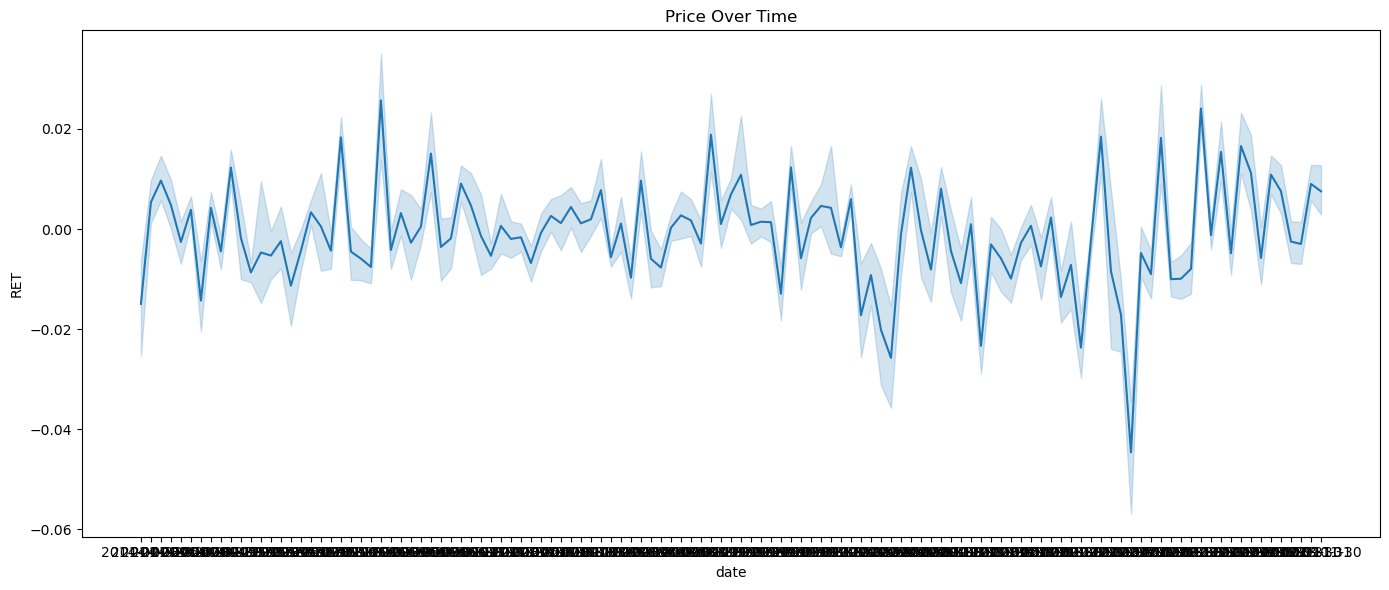

<Figure size 640x480 with 0 Axes>

In [56]:
# Basic statistical description
statistical_description = desc_data.describe()

# Plotting the trends of a few selected metrics over time
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# Plotting CAPEI
sns.lineplot(x='date', y='RET', data=desc_data).set_title('Price Over Time')


plt.tight_layout()
plt.show()

statistical_description
plt.savefig('Price_over_time.png')


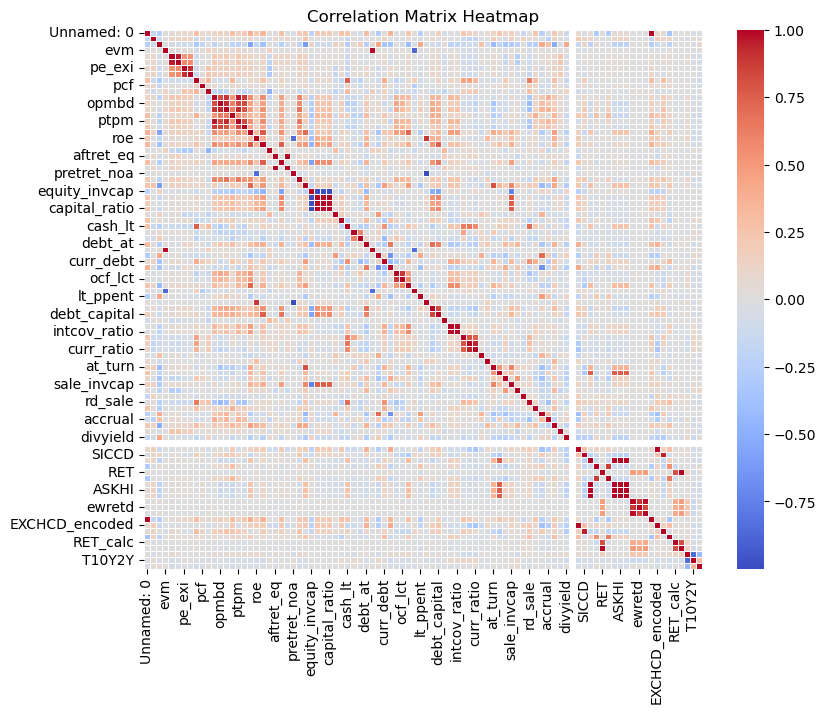

<Figure size 640x480 with 0 Axes>

In [57]:
# Recalculate the correlation matrix
correlation_matrix = desc_data.select_dtypes(include=['number']).drop(columns = 'SHRCD_encoded').corr()

# Set up the matplotlib figure
plt.figure(figsize=(9, 7))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=False, fmt=".1f", linewidths=.5, cmap="coolwarm")
plt.title('Correlation Matrix Heatmap')
plt.show()
plt.savefig('Correlation_matrix_heatmap.png')


/tmp/ipykernel_80953/3573332533.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  desc_data.hist(layout=(-1, 3), bins=np.linspace(-1,1,50), ax=ax);


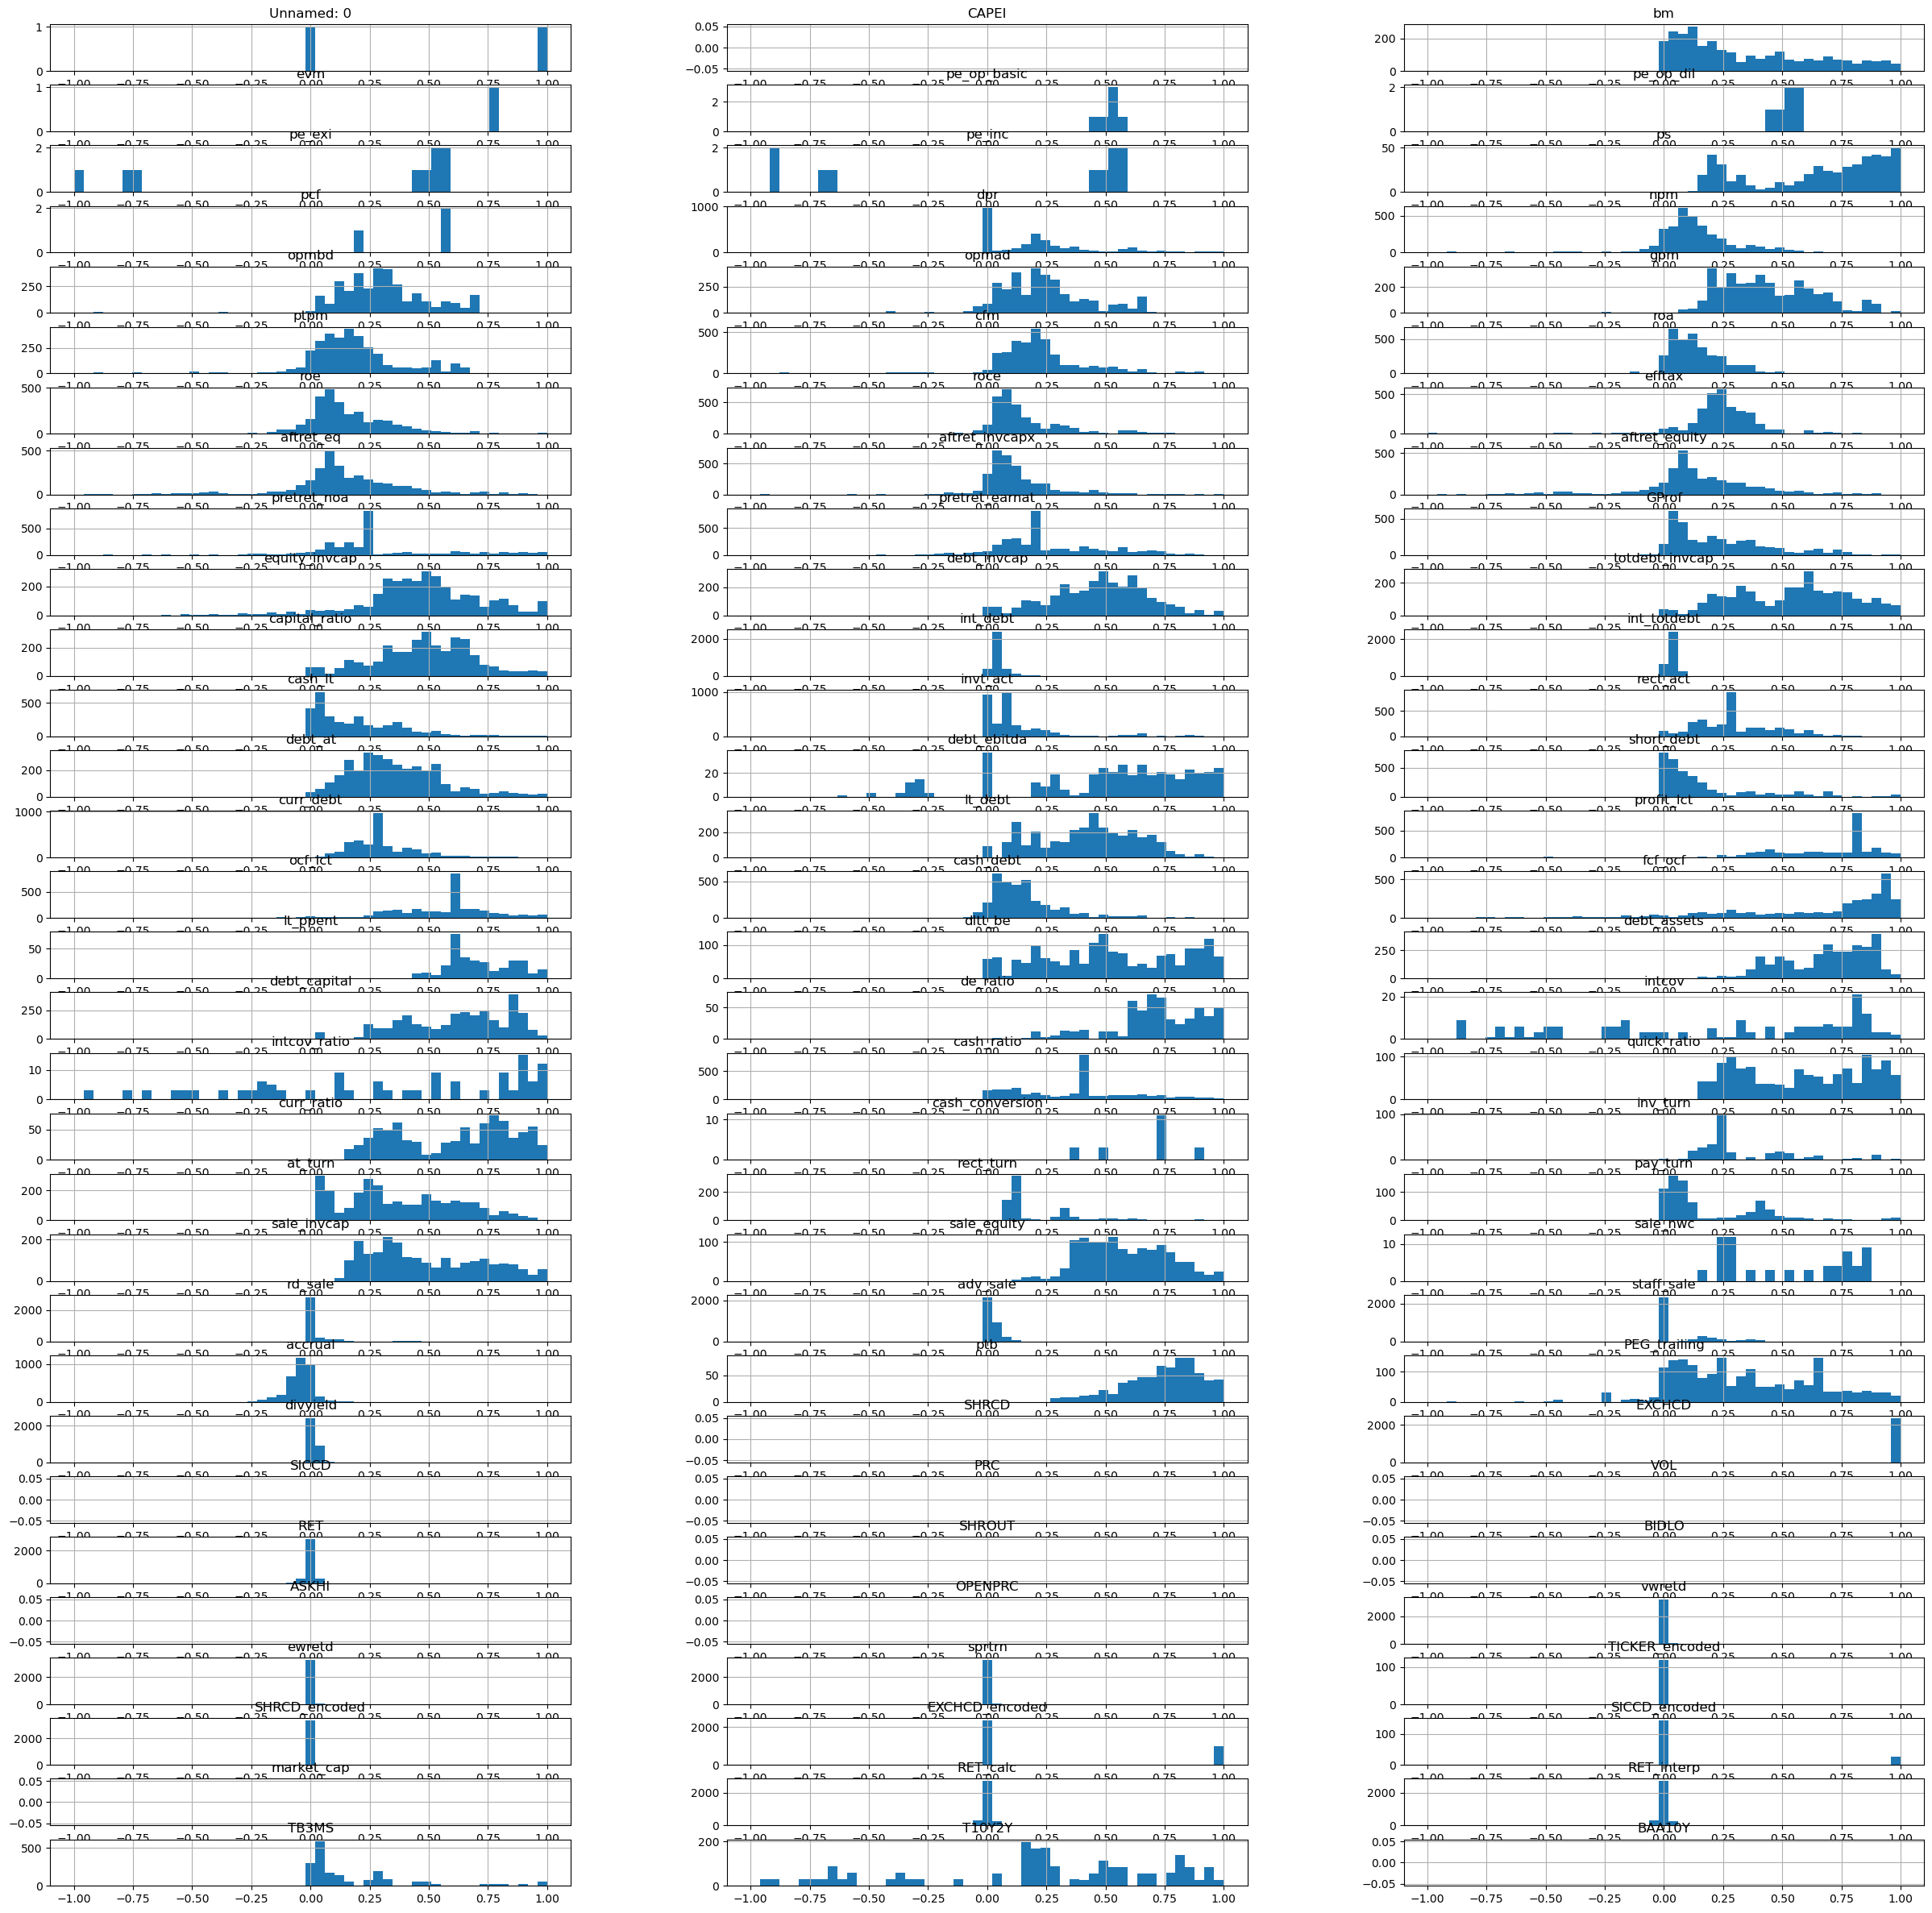

In [58]:
fig, ax = plt.subplots()
fig.set_figheight(30)
fig.set_figwidth(30)
desc_data.hist(layout=(-1, 3), bins=np.linspace(-1,1,50), ax=ax);
plt.savefig('numbers_over_time.png')

/home/onlyartist9/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


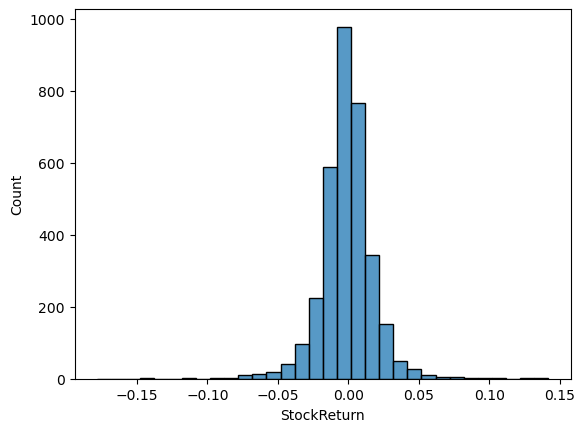

In [59]:
df_3 = desc_data[["RET"]]
df_3 = df_3.rename(columns={'RET': 'StockReturn'})
sns.histplot(data = df_3, x ="StockReturn", binwidth = 0.01, binrange = (df_3["StockReturn"].min()+ 0.00000000001, df_3["StockReturn"].max()- 0.01))
plt.savefig('stock_return.png')

In [60]:
desc_data.columns

Index(['Unnamed: 0', 'TICKER', 'date', 'CAPEI', 'bm', 'evm', 'pe_op_basic',
       'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf', 'dpr', 'npm', 'opmbd',
       'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax',
       'aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa',
       'pretret_earnat', 'GProf', 'equity_invcap', 'debt_invcap',
       'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt',
       'invt_act', 'rect_act', 'debt_at', 'debt_ebitda', 'short_debt',
       'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf',
       'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio',
       'intcov', 'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio',
       'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn', 'pay_turn',
       'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale',
       'staff_sale', 'accrual', 'ptb', 'PEG_trailing', 'divyield', 'COMNAM',
       'SHRCD', 'EXCHCD', 'SICCD', 'PRC

/home/onlyartist9/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


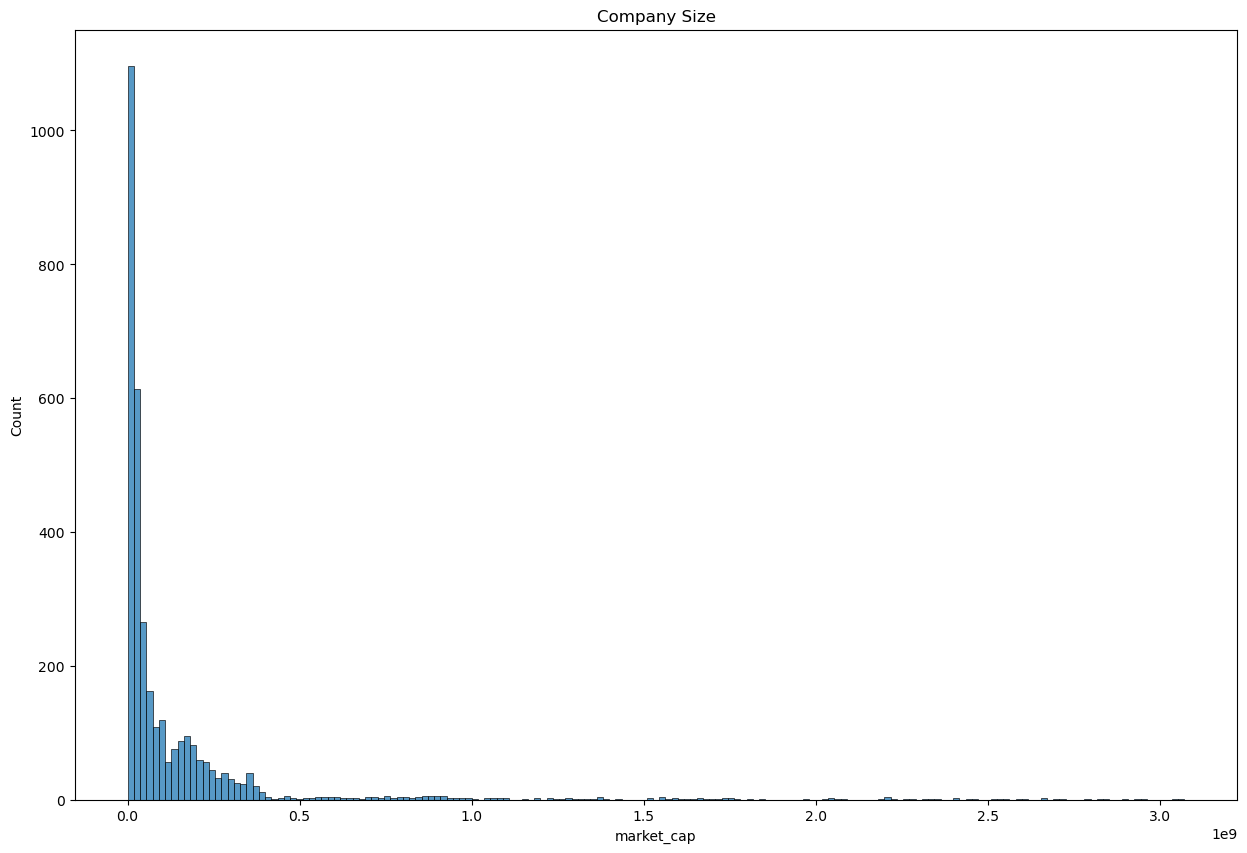

<Figure size 1500x1000 with 0 Axes>

In [61]:
# Set the global size of the figure
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10

# Calculate the maximum market capitalization
max_size = desc_data['market_cap'].max()

# Plot the histogram
ax = sns.histplot(data=desc_data, x="market_cap", binrange=(0, max_size))
ax.set_title('Company Size')  # Set the title

# Save the image to the current folder
plt.savefig('size_distribution.png')  # Ensure the file name is correct

# Show the figure
plt.show()
plt.savefig('company_size.png')

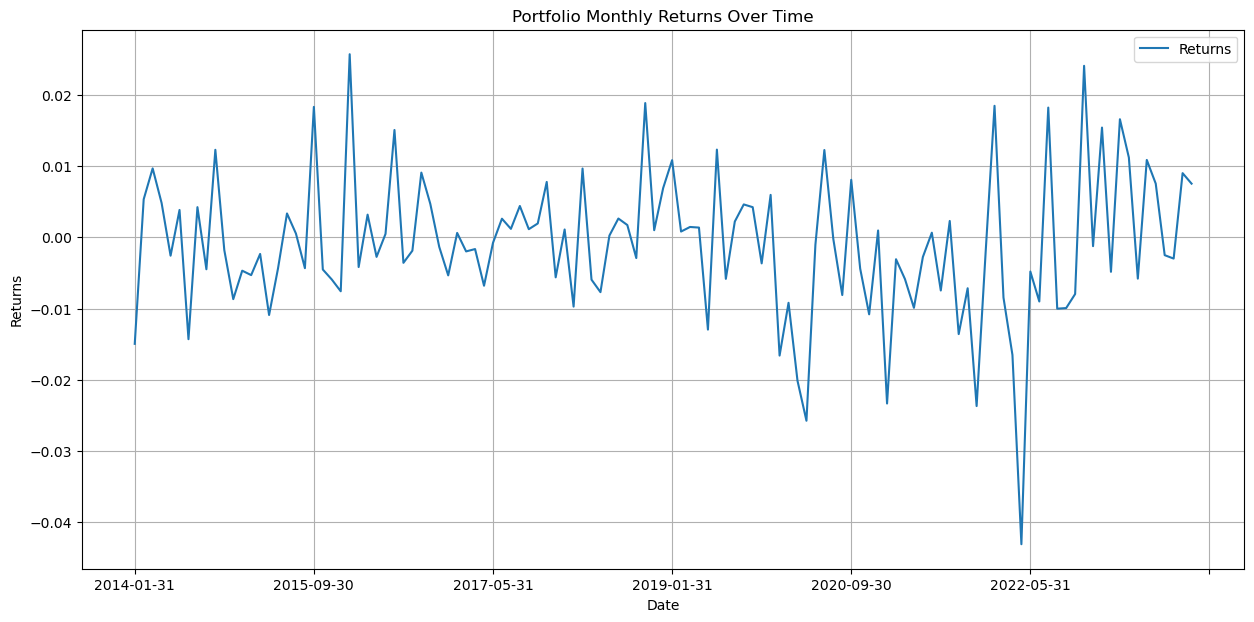

In [62]:
# Assuming final_data is defined
ret_data = desc_data[["RET", "TICKER", "date"]].copy()  # Create a copy to work on to avoid affecting original data

# Create equal weights safely using loc
ret_data['eq_weights'] = 1 / ret_data.groupby('date')['TICKER'].transform('size')

# Calculate monthly return of the equally weighted portfolio containing all stocks
# Use loc to ensure the operation is directly on the DataFrame
ret_data.loc[:, 'return_stock_ew'] = ret_data['RET'].astype(float) * ret_data['eq_weights']

# Calculate the total returns for each date
ret_data.loc[:, 'Returns'] = ret_data.groupby('date')['return_stock_ew'].transform('sum')

# Drop duplicates and set index
unique_ret_data = ret_data[['date', 'Returns']].drop_duplicates().set_index('date')

# Plot the portfolio returns over time
unique_ret_data.plot(grid=True, figsize=(15, 7))
plt.title('Portfolio Monthly Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid(True)

# Save the graph
plt.savefig('portfolio monthly returns over time.png')

In [63]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

number_columns = desc_data.select_dtypes(include=['number'])
c = number_columns.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort").reset_index()
so.columns = ['Variable 1','Variable 2', 'corr']
so = so.sort_values(by = ['corr', 'Variable 1'], ascending = False)
so = so[so['corr']!=1]
so = so.iloc[::2].reset_index(drop=True)
so

,Variable 1,Variable 2,corr
0,PRC,BIDLO,0.999953
1,OPENPRC,ASKHI,0.999949
2,OPENPRC,BIDLO,0.999929
3,PRC,ASKHI,0.999927
4,BIDLO,ASKHI,0.999926
5,debt_invcap,capital_ratio,0.999901
6,PRC,OPENPRC,0.999865
7,equity_invcap,capital_ratio,0.999674
8,aftret_equity,aftret_eq,0.999612
9,equity_invcap,debt_invcap,0.999499


## 3.2 Feature Engineering

In [64]:
df = final_data.copy()

In [65]:
# Ensure data is sorted by TICKER and date
df = df.sort_values(['TICKER', 'date'])

In [69]:
df.head()

,Unnamed: 0,TICKER,date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,divyield,COMNAM,SHRCD,EXCHCD,SICCD,PRC,VOL,RET,SHROUT,BIDLO,ASKHI,OPENPRC,vwretd,ewretd,sprtrn,TICKER_encoded,SHRCD_encoded,EXCHCD_encoded,SICCD_encoded,market_cap,RET_calc,RET_interp,TB3MS,T10Y2Y,BAA10Y,BM,ME,Size,Momentum,ShortTermReversal,LME,LTurnover,DollarVolume,spread,Volatility
0,0,AAPL,2014-01-31,17.588,0.327,7.993,12.506,12.594,12.594,12.594,2.613,8.321,0.288,0.217,0.326,0.287,0.416,0.293,0.256,0.291,0.272,0.379,0.262,0.306,0.281,0.306,1.213,0.601,0.343,0.879,0.121,0.121,0.121,0.016,0.016,0.486,0.024,0.282,0.082,0.304,0.0,0.523,0.203,1.277,1.229,0.643,0.848,5.028,0.121,0.403,0.241,0.675,273.331,360.287,0.929,1.638,1.679,51.691,78.160,0.892,8.690,4.631,1.216,1.383,5.769,0.026,0.006,0.0,-0.087,3.189,0.286,0.0244,APPLE INC,11.0,3.0,3571.0,500.60001,18220292.0,0.001637,891989.0,493.54999,501.53000,495.17999,-0.005796,-0.005268,-0.006465,0.0,0.0,1.0,10.0,4.465297e+08,0.001637,0.001637,0.04,2.464286,2.334762,0.327,4.465297e+08,19.917016,NaN,NaN,NaN,NaN,9.121078e+09,0.016039,0.000000
1,1,AAPL,2014-02-28,18.776,0.296,7.764,0.463,0.466,0.466,0.466,2.698,8.872,0.293,0.213,0.325,0.283,0.416,0.288,0.255,0.284,0.258,0.362,0.262,0.291,0.245,0.291,1.106,0.578,0.350,0.910,0.090,0.090,0.090,0.017,0.017,0.518,0.024,0.255,0.062,0.225,0.0,0.538,0.162,1.337,1.250,0.643,0.852,4.961,0.088,0.381,0.206,0.615,169.323,223.873,0.963,1.645,1.685,51.691,59.513,0.842,9.583,4.965,1.236,1.359,6.003,0.028,0.006,0.0,-0.078,3.172,0.012,0.0232,APPLE INC,11.0,3.0,3571.0,526.23999,13296879.0,-0.002710,891989.0,522.12000,532.75000,529.08002,0.001673,-0.000735,0.002783,0.0,0.0,1.0,10.0,4.694003e+08,-0.002710,-0.002710,0.05,2.382632,2.390000,0.296,4.694003e+08,19.966966,NaN,0.001637,4.465297e+08,0.029778,6.997349e+09,0.020154,0.003074
2,2,AAPL,2014-03-31,18.501,0.296,7.764,0.472,0.475,0.475,0.475,2.658,8.742,0.293,0.213,0.325,0.283,0.416,0.288,0.255,0.284,0.258,0.362,0.262,0.291,0.245,0.291,1.106,0.578,0.350,0.910,0.090,0.090,0.090,0.017,0.017,0.518,0.024,0.255,0.062,0.225,0.0,0.538,0.162,1.337,1.250,0.643,0.852,4.961,0.088,0.381,0.206,0.615,169.323,223.873,0.963,1.645,1.685,51.691,59.513,0.842,9.583,4.965,1.236,1.359,6.003,0.028,0.006,0.0,-0.078,3.125,0.013,0.0227,APPLE INC,11.0,3.0,3571.0,536.73999,6023884.0,-0.000224,861745.0,535.92999,540.81000,539.22998,0.009182,0.010512,0.007924,0.0,0.0,1.0,10.0,4.625330e+08,-0.000224,-0.000224,0.05,2.324286,2.340952,0.296,4.625330e+08,19.952228,NaN,-0.002710,4.694003e+08,0.012833,3.233259e+09,0.009064,0.002181
3,3,AAPL,2014-04-30,20.332,0.296,7.764,0.519,0.523,0.523,0.523,2.921,9.607,0.293,0.213,0.325,0.283,0.416,0.288,0.255,0.284,0.258,0.362,0.262,0.291,0.245,0.291,1.106,0.578,0.350,0.910,0.090,0.090,0.090,0.017,0.017,0.518,0.024,0.255,0.062,0.225,0.0,0.538,0.162,1.337,1.250,0.643,0.852,4.961,0.088,0.381,0.206,0.615,169.323,223.873,0.963,1.645,1.685,51.691,59.513,0.842,9.583,4.965,1.236,1.359,6.003,0.028,0.006,0.0,-0.078,3.435,0.014,0.0207,APPLE INC,11.0,3.0,3571.0,590.09003,16317269.0,-0.003782,861381.0,589.79999,599.42999,592.64001,0.003405,0.002607,0.002992,0.0,0.0,1.0,10.0,5.082923e+08,-0.003782,-0.003782,0.03,2.288095,2.199048,0.296,5.082923e+08,20.046567,NaN,-0.000224,4.625330e+08,0.035278,9.628658e+09,0.016195,0.002445
4,4,AAPL,2014-05-31,20.513,0.302,7.873,0.537,0.540,0.540,0.540,3.097,10.108,0.292,0.214,0.328,0.286,0.421,0.290,0.257,0.280,0.260,0.357,0.262,0.295,0.241,0.295,1.121,0.57

In [66]:
existing_vars = [
    'market_cap',  # ME (Market Equity)
    'bm',          # Book-to-Market
    'pe_op_basic', # E2P (inverse)
    'pe_op_dil',   # Another version of E2P (inverse)
    'npm',         # Similar to PM (Profit Margin)
    'gpm',         # Similar to PCM (Price-to-Cost Margin)
    'roa',         # Return on Assets
    'roe',         # Return on Equity
    'ps',          # Price to Sales (inverse of S2P)
    'debt_assets', # Similar to Lev (Leverage)
    'at_turn',     # Similar to ATO (Asset Turnover)
    'accrual',     # Might correspond to OA (Operating Accruals)
    'divyield',    # Dividend Yield
]
benchmark = ['Size','Momentum','BM']

Part of the 94 indicators from Green et al. (2017)
Macroeconomic indicators from Welch and Goyal (2008): Treasury-bill rate (tbl), term spread (tms), default spread (dfy)

Market-related indicators:
- ME (Market Equity): Total market value at the company level
- LME: Total market value at the end of last month
- LTurnover: Ratio of total trading volume last month to total market value at the end of last month
- Spread: Average daily bid-ask spread last month
- Beta: Beta value calculated according to Frazzini and Pedersen (2014)
- Idio vol (Idiosyncratic Volatility): Idiosyncratic volatility calculated based on the method of Ang et al. (2006)

Historical return indicators:
- r2−1: Lagged return of last month
- r12−2: Return over the past 12 months (excluding the last month)
- r12−7: Medium-term momentum (return from 12 months ago to 7 months ago)
- r36−13: Long-term return (return from 3 years ago to last year)

Financial statement indicators:
- BE (Book Equity): Book equity
- BM (Book-to-Market): Book-to-market ratio
- AT: Total assets
- ATO: Sales divided by net operating assets
- C (Cash): Ratio of cash and short-term investments to total assets
- CTO: Capital turnover rate
- D2A: Ratio of depreciation and amortization to total assets
- DPI2A: Change in fixed assets
- E2P: Inverse of the price-to-earnings ratio
- FC2Y: Expense-to-sales ratio (sum of advertising, R&D, and SG&A expenses divided by sales)
- Free CF: Free cash flow
- Investment: Total asset growth rate
- Lev: Leverage ratio (total debt / (total debt + shareholders’ equity))
- NOA: Ratio of net operating assets to lagged total assets
- OA: Operating accruals (defined according to Sloan (1996))
- OL: Operating leverage (cost of goods sold and SG&A expenses divided by total assets)
- PCM: Price-cost margin ((sales - cost of goods sold) / sales)
- PM: Operating profit margin (operating income after depreciation / net sales)
- Prof: Gross profit margin (gross profit / book value of equity)
- Q: Tobin’s Q
- Rel to high: Proximity to the 52-week high price
- RNA: Return on net operating assets
- ROA: Return on assets (pre-tax profit / total assets)
- ROE: Return on equity (pre-tax profit / lagged book value of equity)
- S2P: Sales-to-price ratio
- SGA2S: SG&A expense ratio (SG&A expenses / net sales)
- SUV: Standardized unexpected volume

### According to Gu (2020), we can categorize the features as follows:

Benchmark Features (3):
- Size
- Book-to-Market ratio
- Momentum

Stock-Level Predictors (mainly divided into three categories): 
a. Price Trend Variables:
- Stock Momentum
- Industry Momentum
- Short-term Reversal

b. Liquidity Variables:
- Market Equity
- Dollar Trading Volume
- Bid-Ask Spread

c. Volatility Related:
- Return Volatility
- Idiosyncratic Volatility
- Market Beta
- Beta Squared

d. Macroeconomic Predictors (8):
- Dividend-Price Ratio (dp)
- Earnings-Price Ratio (ep)
- Book-to-Market Ratio (bm)
- Net Equity Expansion (ntis)
- Treasury-bill Rate (tbl)
- Term Spread (tms)
- Default Spread (dfy)
- Stock Variance (svar)

## Processing Steps:
- Benchmark Features and Main Stock-Level Predictors:These features can mostly be calculated or extracted directly from CRSP data.
- Macroeconomic Predictors: These require additional macroeconomic data sources, which may need to be obtained from Federal Reserve Economic Data (FRED) or other economic databases.
- 94 Predictive Features: These features are based on Green et al. (2017) and require the use of financial statement data (e.g., Compustat) combined with market data for calculation.

## Data Alignment: 

- Monthly Features: Use end-of-month data for month t to predict returns for month t+1.
- Quarterly Features: Use data from at least 4 months ago.
- Annual Features: Use data from at least 6 months ago.

## Handling Missing Values:
For missing features, use the cross-sectional median of each stock for each month to fill in the gaps.

Based on the information you provided, I will help you organize the required variables, existing variables, and missing variables.

Required Variables (based on your requirements):
a. Benchmark Features:

Size (existing)
Book-to-Market ratio (existing, corresponding to ‘bm’)
Momentum (existing)
b. Stock-Level Predictors:

Stock Momentum (existing, corresponding to ‘Momentum’)
Industry Momentum (missing)
Short-term Reversal (existing, corresponding to ‘ShortTermReversal’)
Market Equity (existing, corresponding to ‘ME’ or ‘market_cap’)
Dollar Trading Volume (existing, corresponding to ‘DollarVolume’)
Bid-Ask Spread (existing, corresponding to ‘spread’)
Return Volatility (can be calculated from ‘RET’)
Idiosyncratic Volatility (existing, corresponding to ‘Idio_vol’)
Market Beta (existing, corresponding to ‘Beta’)
Beta Squared (existing, corresponding to ‘BetaSquared’)
c. Macroeconomic Predictors:

Dividend-Price Ratio (dp) (existing, corresponding to ‘divyield’)
Earnings-Price Ratio (ep) (can be obtained from the inverse of ‘pe_op_basic’ or ‘pe_op_dil’)
Book-to-Market Ratio (bm) (existing)
Net Equity Expansion (ntis) (missing)
Treasury-bill Rate (tbl) (possibly corresponding to ‘TB3MS’, needs confirmation)
Term Spread (tms) (possibly corresponding to ‘T10Y2Y’, needs confirmation)
Default Spread (dfy) (possibly corresponding to ‘BAA10Y’, needs confirmation)
Stock Variance (svar) (can be calculated from ‘RET’)
Important Existing Variables (in addition to the above):
‘roa’, ‘roe’, ‘roce’ (profitability indicators)
‘debt_assets’, ‘debt_capital’, ‘de_ratio’ (leverage indicators)
‘cash_ratio’, ‘quick_ratio’, ‘curr_ratio’ (liquidity indicators)
‘at_turn’, ‘inv_turn’ (efficiency indicators)
‘accrual’ (quality indicator)
‘PRC’, ‘VOL’, ‘SHROUT’ (price, trading volume, shares)
‘vwretd’, ‘ewretd’, ‘sprtrn’ (market return indicators)
Important Missing Variables:
Industry Momentum
Net Equity Expansion (ntis)
Possibly Unnecessary Variables (depending on your specific research purpose, but these variables may be redundant or less commonly used):
‘CAPEI’ (if ‘pe_op_basic’ or ‘pe_op_dil’ is available)
‘evm’ (if ‘bm’ is available)
‘pe_exi’, ‘pe_inc’ (if ‘pe_op_basic’ or ‘pe_op_dil’ is available)
‘ptpm’ (if ‘npm’ is available)
‘pcf’ (if ‘ps’ and ‘cfm’ are available)
‘aftret_eq’, ‘aftret_invcapx’, ‘aftret_equity’ (if ‘roe’ and ‘roce’ are available)
‘pretret_noa’, ‘pretret_earnat’ (if other profitability indicators are available)
‘equity_invcap’, ‘debt_invcap’, ‘totdebt_invcap’ (if ‘debt_capital’ and ‘de_ratio’ are available)
‘intcov’, ‘intcov_ratio’ (possibly redundant)
‘sale_invcap’, ‘sale_equity’, ‘sale_nwc’ (if ‘ps’ and other efficiency indicators are available)
‘int_debt’, ‘int_totdebt’ (if other debt indicators are available)
‘invt_act’, ‘rect_act’ (if ‘curr_ratio’ and ‘quick_ratio’ are available)
‘short_debt’, ‘curr_debt’, ‘lt_debt’ (if ‘debt_assets’ and ‘debt_capital’ are available)
‘ptb’ (if ‘bm’ is available)
‘PEG_trailing’ (if ‘pe_op_basic’ or ‘pe_op_dil’ and growth rate indicators are available)
For missing variables and those that need to be calculated, you may need to obtain additional data or use existing data for calculations. For example, industry momentum may require industry classification data, while return volatility and stock variance can be calculated using existing return data.

In [70]:
def calculate_variables(df):
    # 0 benchmark
    df['BM'] = df['bm']
    
    # ME (Market Equity)
    df['ME'] = df['market_cap']
    
    # Size (natural log of ME)
    df['Size'] = np.log(df['ME'])
    
    # Momentum (11-month return, 1 month ago)
    def calculate_momentum(group):
        return group.rolling(window=11).apply(lambda x: (1 + x).prod() - 1).shift(1)

    df['Momentum'] = df.groupby('TICKER')['RET'].transform(calculate_momentum)

    # 1 Market-related indicators
    # Short-term reversal (return from the past month)
    df['ShortTermReversal'] = df.groupby('TICKER')['RET'].shift(1)
    
    # Calculate market capitalization
    df['market_cap'] = df['PRC'].abs() * df['SHROUT']
    
    # LME (Lagged Market Equity) Total market capitalization at the end of last month
    df['LME'] = df.groupby('TICKER')['market_cap'].shift(1)
    
    # LTurnover Ratio of total trading volume last month to total market capitalization at the end of last month
    df['LTurnover'] = df['VOL'] / df['LME']
    
    # Dollar trading volume
    df['DollarVolume'] = df['PRC'].abs() * df['VOL']

    # Spread Average daily bid-ask spread last month
    df['spread'] = (df['ASKHI'] - df['BIDLO']) / ((df['ASKHI'] + df['BIDLO']) / 2)
    
    # Calculate 20-day rolling standard deviation
    df['Volatility'] = df.groupby('TICKER')['RET'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
    # Handle possible NaN values
    df['Volatility'] = df['Volatility'].fillna(0)

    # Beta (simplified version) calculated using rolling window
    def calculate_beta(stock_returns, market_returns, window=252):
        return stock_returns.rolling(window=window).apply(lambda x: np.cov(x, market_returns[-window:])[0,1] / np.var(market_returns[-window:]))
    
    df['Beta'] = df.groupby('TICKER')['RET'].apply(lambda x: calculate_beta(x, df['sprtrn']))

    # Calculate Beta squared
    df['BetaSquared'] = df['Beta'] ** 2

    # 2 Historical return indicators
    # Historical returns
    df['r2_1'] = df.groupby('TICKER')['RET'].shift(1)

    # Reset index
    df_reset = df.reset_index()
    
    # Calculate r12_2
    df_reset['r12_2'] = df_reset.groupby('TICKER')['RET'].rolling(window=11).sum().shift(1).reset_index(0, drop=True)
    df_reset['r12_7'] = df_reset.groupby('TICKER')['RET'].rolling(window=6).sum().shift(6).reset_index(0, drop=True)
    df_reset['r36_13'] = df_reset.groupby('TICKER')['RET'].rolling(window=24).sum().shift(12).reset_index(0, drop=True)

    # Set back to original index
    df_reset.set_index('index', inplace=True)
    
    # Assign results to original DataFrame
    df['r12_2'] = df_reset['r12_2']
    df['r12_7'] = df_reset['r12_7']
    df['r36_13'] = df_reset['r36_13']

    # 3 Financial statement indicators
    # Reset index
    df_reset = df.reset_index()

    # Rel to high Degree of closeness to the 52-week high price
    df_reset['52_week_high'] = df_reset.groupby('TICKER')['PRC'].rolling(window=252).max().reset_index(0, drop=True)
    
    # Calculate Rel_to_high
    df_reset['Rel_to_high'] = df_reset['PRC'] / df_reset['52_week_high']
    
    # Set back to original index
    df_reset.set_index('index', inplace=True)
    
    # Assign results to original DataFrame
    df['52_week_high'] = df_reset['52_week_high']
    df['Rel_to_high'] = df_reset['Rel_to_high']
    
    # SUV (Standardized Unexplained Volume)
    def calculate_suv(volume, window=20):
        log_volume = np.log(volume)
        mean_log_volume = log_volume.rolling(window=window).mean()
        std_log_volume = log_volume.rolling(window=window).std()
        return (log_volume - mean_log_volume) / std_log_volume
    
    df['SUV'] = df.groupby('TICKER')['VOL'].apply(calculate_suv)
    
    return df

# Apply the function to your dataframe
df = calculate_variables(df)

TypeError: incompatible index of inserted column with frame index

In [ ]:
# Calculate missing value statistics and convert to DataFrame
null_summary = pd.DataFrame(df.isnull().sum(), columns=['MissingValueCount'])

# Temporarily change display settings using option_context and directly display DataFrame
with pd.option_context('display.max_columns', None, 'display.max_colwidth', 20):
    display(null_summary)

# Save the summary to a CSV file
null_summary.to_csv("missing_value_summary.csv")

In [ ]:
def handle_missing_values(df):
    # Use forward fill for historical return indicators
    historical_returns = ['Momentum', 'r12_2', 'r12_7', 'r36_13', 'ShortTermReversal', 'LME', 'LTurnover', 'r2_1']
    df[historical_returns] = df.groupby('TICKER')[historical_returns].fillna(method='ffill')
    df[historical_returns] = df.groupby('TICKER')[historical_returns].fillna(method='bfill')
    df[historical_returns] = df[historical_returns].fillna(df[historical_returns].median())

    # Use median fill for trading-related indicators
    trading_indicators = ['DollarVolume', 'spread']
    df[trading_indicators] = df[trading_indicators].fillna(df[trading_indicators].median())
    
    # Use 0 fill for SUV
    df['SUV'] = df['SUV'].fillna(0)
    
    return df

# Apply the function
df = handle_missing_values(df)

In [ ]:
def clean_and_fill_numeric(df, var):
    # Attempt to convert data to numeric type
    df[var] = pd.to_numeric(df[var], errors='coerce')    
    return df
    
# Apply this function to each variable that needs processing
variables_to_clean = ['Momentum', 'r12_2', 'r12_7', 'r36_13', 'sprtrn', 'RET']  # Add all variables that need processing
for var in variables_to_clean:
    df = clean_and_fill_numeric(df, var)

In [ ]:
print(df['Momentum'].head())  # Check the first few rows of data
print(df['Momentum'].isnull().sum())  # Count the number of NaN values

In [ ]:
def handle_remaining_missing_values(df):
    # Handle Momentum and long-term return indicators
    long_term_vars = ['Momentum', 'r12_2', 'r12_7', 'r36_13']
    for var in long_term_vars:
        df[var] = df.groupby('SICCD')[var].transform(lambda x: x.fillna(x.median()))
        df[var] = df[var].fillna('median')

    # Get companies still missing Momentum
    missing_momentum_companies = df[df['Momentum'].isna()]['TICKER'].unique()
    # Fill using industry average
    df['Momentum'] = df.groupby('SICCD')['Momentum'].transform(lambda x: x.fillna(x.mean()))
    # Fill using overall median
    df['Momentum'] = df['Momentum'].fillna(df['Momentum'].median())

    # Handle short-term indicators
    short_term_vars = ['ShortTermReversal', 'LME', 'LTurnover', 'r2_1']
    df[short_term_vars] = df.groupby('TICKER')[short_term_vars].fillna(method='ffill')
    df[short_term_vars] = df.groupby('TICKER')[short_term_vars].fillna(method='bfill')
    df[short_term_vars] = df[short_term_vars].fillna(df[short_term_vars].median())

    for var in short_term_vars:
        df[var] = df.groupby('SICCD')[var].transform(lambda x: x.fillna(x.median()))
    
    # Recalculate Beta and related indicators
    def calculate_beta(stock_returns, market_returns, window=60):
        return stock_returns.rolling(window=window).apply(lambda x: np.cov(x, market_returns[-window:])[0,1] / np.var(market_returns[-window:]))

    df['Beta'] = df.groupby('TICKER')['RET'].apply(lambda x: calculate_beta(x, df['sprtrn']))
    df['BetaSquared'] = df['Beta'] ** 2
    
    # Fill Beta-related indicators using industry average
    beta_indicators = ['Beta', 'BetaSquared']
    for indicator in beta_indicators:
        df[indicator] = df.groupby('TICKER')[indicator].transform(lambda x: x.fillna(x.median()))
    
    # If there are still missing values (e.g., some companies might be all NaN), fill using overall median
    for indicator in beta_indicators:
        df[indicator] = df[indicator].fillna(df[indicator].median())
    
    # Use industry median
    # df[indicator] = df.groupby('SICCD')[indicator].transform(lambda x: x.fillna(x.mean()))
    # # If there are still missing values, fill using overall median
    # df[indicator] = df[indicator].fillna(df[indicator].median())

    # Use 3-month high instead of 52-week high for related indicators
    df['3_month_high'] = df.groupby('TICKER')['PRC'].rolling(window=63).max().reset_index(0, drop=True)
    df['Rel_to_3month_high'] = df['PRC'] / df['3_month_high']
    
    # Use 1-month high
    df['1_month_high'] = df.groupby('TICKER')['PRC'].rolling(window=21).max().reset_index(0, drop=True)
    df['Rel_to_1month_high'] = df['PRC'] / df['1_month_high']
    
    # Handle possible missing values
    df['52_week_high'] = df.groupby('TICKER')['52_week_high'].fillna(method='ffill', limit=3)
    df['Rel_to_high'] = df.groupby('TICKER')['Rel_to_high'].fillna(method='ffill', limit=3)

    # If there are still missing values, fill 52-week high using 3-month high
    df['52_week_high'] = df['52_week_high'].fillna(df['3_month_high'])
    df['Rel_to_high'] = df['Rel_to_high'].fillna(df['Rel_to_3month_high'])

    # If there are still missing values, fill 52-week high using 1-month high
    df['52_week_high'] = df['52_week_high'].fillna(df['1_month_high'])
    df['Rel_to_high'] = df['Rel_to_high'].fillna(df['Rel_to_1month_high'])

    # If there are still missing values, fill 52-week high using current price, and set Rel_to_high to 1
    df['52_week_high'] = df['52_week_high'].fillna(df['PRC'])
    df['Rel_to_high'] = df['Rel_to_high'].fillna(1)
    
    return df

# Apply the function
df = handle_remaining_missing_values(df)

In [ ]:
def calculate_rolling_beta_and_idio_vol(group, market_returns, window=60):
    # Calculate rolling Beta
    returns = group['RET']
    covariance = returns.rolling(window=window).cov(market_returns)
    market_variance = market_returns.rolling(window=window).var()
    beta = covariance / market_variance

    # Calculate rolling idiosyncratic volatility
    residuals = returns - beta * market_returns
    idio_vol = residuals.rolling(window=window).std()

    return pd.DataFrame({'Beta': beta, 'Idio_vol': idio_vol})

# Apply calculation
result = df.groupby('TICKER').apply(
    lambda group: calculate_rolling_beta_and_idio_vol(group, df.loc[group.index, 'sprtrn'])
).reset_index(level=0, drop=True)

df['Beta'] = result['Beta']
df['Idio_vol'] = result['Idio_vol']

# Fill missing values
for indicator in ['Beta', 'Idio_vol']:
    df[indicator] = df.groupby('TICKER')[indicator].transform(lambda x: x.fillna(x.median()))
    df[indicator] = df[indicator].fillna(df[indicator].median())

# Handle extreme values (optional)
for indicator in ['Beta', 'Idio_vol']:
    low = df[indicator].quantile(0.01)
    high = df[indicator].quantile(0.99)
    df[indicator] = df[indicator].clip(low, high)

# Calculate BetaSquared
df['BetaSquared'] = df['Beta'] ** 2

In [ ]:
def handle_missing_values_small_missing(df):
    # Handle categorical variables
    category_vars = ['COMNAM', 'SHRCD', 'EXCHCD', 'SICCD', 'TICKER_encoded', 'SHRCD_encoded', 'EXCHCD_encoded', 'SICCD_encoded']
    df[category_vars] = df.groupby('TICKER')[category_vars].fillna(method='ffill')

    # Handle numeric variables
    numeric_vars = ['PRC', 'VOL', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC', 'vwretd', 'ewretd', 'sprtrn', 'RET_calc', 'RET_interp']
    df[numeric_vars] = df.groupby('TICKER')[numeric_vars].transform(lambda x: x.interpolate(method='linear'))

    # Special handling for RET
    df['RET'] = df.groupby('TICKER')['RET'].fillna(0)  

    # Recalculate market_cap, ME, and Size
    df['market_cap'] = df['PRC'].abs() * df['SHROUT']
    df['ME'] = df['market_cap']
    df['Size'] = np.log(df['ME'])

    return df

# Apply the function
df = handle_missing_values_small_missing(df)

In [ ]:
# Calculate missing value statistics and convert to DataFrame
null_summary = pd.DataFrame(df.isnull().sum(), columns=['MissingValueCount'])

# Temporarily change display settings using option_context and directly display DataFrame
with pd.option_context('display.max_columns', None, 'display.max_colwidth', 20):
    display(null_summary)

# Save the summary to a CSV file
null_summary.to_csv("missing_value_summary.csv")

In [ ]:
df.set_index('date',inplace = True)

In [ ]:
df.index

In [ ]:
df.to_csv("final_data_after_missing_value_handle.csv")

In [ ]:
df_columns = pd.DataFrame(df.columns)
df_columns.to_csv('final_data_columns.csv')
print('output df columns')

## 3.3 Model Training

## Normalization(FR)

In [ ]:
data = df.copy()

In [ ]:
try:
    data = data.drop(['level_0_stk','index_stk','3_month_high', 'Rel_to_3month_high', '1_month_high', 'Rel_to_1month_high', 'RET_calc', 'RET_interp'], axis=1)
except KeyError as e:
    print(f"Columns not found: {e}")


In [ ]:
data.columns

In [ ]:
data.describe()

In [ ]:
# handle fin related data
# Handle infinite and NaN values
data = data.replace([np.inf, -np.inf], np.nan)

# Create a new DataFrame to store normalized data
normalized_data = pd.DataFrame(index=data.index)

# 1. MinMaxScaler for most financial ratios
minmax_cols = ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'dpr', 'npm', 
               'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax']
minmax_scaler = MinMaxScaler()
for date in normalized_data.index.unique():
    normalized_data[minmax_cols] = minmax_scaler.fit_transform(data[minmax_cols].fillna(data[minmax_cols].mean()))

# 2. Log transformation followed by StandardScaler for highly skewed positive data
log_standard_cols = ['ps', 'pcf', 'debt_ebitda', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio']
log_standard_scaler = StandardScaler()
for col in log_standard_cols:
    for date in normalized_data.index.unique():
        # Set negative values to a very small positive number
        temp_data = data[col].clip(lower=1e-8)
        normalized_data[col] = log_standard_scaler.fit_transform(np.log1p(temp_data).values.reshape(-1, 1))

# 3. Yeo-Johnson transformation for financial metrics that may include negative values
yeojohnson_cols = ['aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf']
pt_yeo = PowerTransformer(method='yeo-johnson')
for date in normalized_data.index.unique():
    normalized_data[yeojohnson_cols] = pt_yeo.fit_transform(data[yeojohnson_cols].fillna(data[yeojohnson_cols].mean()))

# 4. For ratio data between 0 and 1, use scaling instead of logit transformation
ratio_cols = ['equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio']
ratio_scaler = MinMaxScaler(feature_range=(0.001, 0.999))  # Avoid 0 and 1
for date in normalized_data.index.unique():
    normalized_data[ratio_cols] = ratio_scaler.fit_transform(data[ratio_cols].fillna(data[ratio_cols].mean()))

# 5. For turnover rates and conversion days, use Yeo-Johnson instead of Box-Cox
turn_cols = ['inv_turn', 'at_turn', 'rect_turn', 'pay_turn', 'cash_conversion']
pt_yeo_turn = PowerTransformer(method='yeo-johnson')
for date in normalized_data.index.unique():
    normalized_data[turn_cols] = pt_yeo_turn.fit_transform(data[turn_cols].fillna(data[turn_cols].mean()))

# 6. QuantileTransformer for metrics that may have extreme values
quantile_cols = ['intcov', 'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'sale_invcap', 'sale_equity', 'sale_nwc']
qt = QuantileTransformer(output_distribution='normal')
for date in normalized_data.index.unique():
    normalized_data[quantile_cols] = qt.fit_transform(data[quantile_cols].fillna(data[quantile_cols].mean()))

# 7. RobustScaler for other columns that may contain outliers
robust_cols = ['int_debt', 'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at', 'short_debt', 'curr_debt', 'lt_debt', 
               'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb', 'PEG_trailing', 'divyield']
robust_scaler = RobustScaler()
for date in normalized_data.index.unique():
    normalized_data[robust_cols] = robust_scaler.fit_transform(data[robust_cols].fillna(data[robust_cols].mean()))

# Check if all columns have been processed
unprocessed_cols = set(numeric_columns) - set(normalized_data.columns)
if unprocessed_cols:
    print(f"Warning: The following columns were not processed: {unprocessed_cols}")
    # For unprocessed columns, you can choose to either copy the original values or apply the default StandardScaler
    for col in unprocessed_cols:
        for date in normalized_data.index.unique():
            normalized_data[col] = StandardScaler().fit_transform(data[[col]].fillna(data[col].mean()))


In [ ]:
normalized_data.index

In [ ]:
# handle stock and econ related data

# Create scalers
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Select features for Min-Max normalization
min_max_features = [
    'vwretd', 'ewretd', 'sprtrn',
    'Beta', 'BetaSquared', 'Idio_vol', 'spread', 'BM', 'ME', 'Size',
    'Momentum', 'ShortTermReversal', 'LME', 'LTurnover'
]

# Select features for Z-score standardization
z_score_features = [
    'PRC', 'VOL', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC',
    'market_cap', 'TB3MS', 'T10Y2Y', 'BAA10Y', 'DollarVolume'
]

# Perform Min-Max normalization
for date in normalized_data.index.unique():
    normalized_data[min_max_features] = min_max_scaler.fit_transform(data[min_max_features])

# Perform Z-score standardization
for date in normalized_data.index.unique():
    normalized_data[z_score_features] = standard_scaler.fit_transform(data[z_score_features])

# Display normalized data
print(normalized_data.head())

Rank standardization in inreval [-1,1]
A rank standardization procedure following Kelly, Pruitt, and Su (2019) and Freyberger, Neuhierl, and Weber (2020) is employed. The stock characteristics are ranked month-by-month cross-sectionally and the ranks are mapped into the [-1,1] interval, thereby transforming features into a uniform distribution and increasing the insensitivity to outliers

In [ ]:
temp_nor_data = normalized_data.copy()

In [ ]:
all_features = (minmax_cols + log_standard_cols + yeojohnson_cols +
                ratio_cols + turn_cols + quantile_cols + robust_cols +
                min_max_features + z_score_features)

# Group by each month (indicated by the 'eom' column) and then rank these features by percentile
temp_nor_data[all_features] = temp_nor_data[all_features].rank(pct=True)

# Convert the rankings to the [-1, 1] range
temp_nor_data[all_features] = 2 * temp_nor_data[all_features] - 1

# Check the transformation results
print(temp_nor_data[all_features].head())

In [ ]:
temp_nor_data['TICKER'] = data['TICKER']
temp_nor_data['RET'] = data['RET']

In [ ]:
# Save the normalized data
temp_nor_data.to_csv('temp_nor_data.csv', index=False)

print("Normalization completed. Data saved to 'normalized_data.csv'")

# Model Training

In [ ]:
model_data = temp_nor_data.copy()

In [ ]:
# Variables that may need to be dropped
variables_to_drop = [
    'CAPEI', 'evm', 'pe_exi', 'pe_inc', 'ptpm', 'pcf',
    'aftret_eq', 'aftret_invcapx', 'aftret_equity',
    'pretret_noa', 'pretret_earnat',
    'equity_invcap', 'debt_invcap', 'totdebt_invcap',
    'intcov', 'intcov_ratio',
    'sale_invcap', 'sale_equity', 'sale_nwc',
    'int_debt', 'int_totdebt',
    'invt_act', 'rect_act',
    'short_debt', 'curr_debt', 'lt_debt',
    'ptb', 'PEG_trailing'
]

# Variables that need to be kept
variables_to_keep = [
    # Benchmark features
    'Size', 'bm', 'Momentum',
    
    # Stock-level predictors
    'ShortTermReversal', 'ME', 'market_cap', 'DollarVolume', 'spread',
    'RET', 'Idio_vol', 'Beta', 'BetaSquared',
    
    # Macroeconomic predictors
    'divyield', 'pe_op_basic', 'pe_op_dil', 'TB3MS', 'T10Y2Y', 'BAA10Y',
    
    # Other important financial indicators
    'roa', 'roe', 'roce', 'debt_assets', 'debt_capital', 'de_ratio',
    'cash_ratio', 'quick_ratio', 'curr_ratio', 'at_turn', 'inv_turn',
    'accrual',
    
    # Price and trading related
    'PRC', 'VOL', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC',
    
    # Market return indicators
    'vwretd', 'ewretd', 'sprtrn',
    
    # Other potentially useful indicators
    'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'cfm', 'efftax', 'ps',
    'debt_ebitda', 'lt_ppent', 'dltt_be', 'capital_ratio',
    'rect_turn', 'pay_turn', 'cash_conversion',
    'cash_lt', 'debt_at', 'profit_lct', 'ocf_lct',
    'cash_debt', 'fcf_ocf', 'rd_sale', 'adv_sale', 'staff_sale',
    
    # Other calculated indicators
    'LME', 'LTurnover',
    
    # Identifiers
    'TICKER'
]

# Use these lists to select or drop variables
# model_data = model_data[variables_to_keep]
# Keep all

# # Or
# df_dropped = df.drop(columns=variables_to_drop)

# Print list lengths to check
# print(f"Number of variables to drop: {len(variables_to_drop)}")
# print(f"Number of variables to keep: {len(variables_to_keep)}")

# try:
#     rf_data = rf_data.drop([''], axis=1)
# except KeyError as e:
#     print(f"Columns not found: {e}")

# Not selecting variables because the results were not good

In [ ]:
model_data.columns

In [ ]:
columns_have_nan = ['ShortTermReversal','LME','LTurnover']
try:
    model_data[columns_have_nan] = model_data[columns_have_nan].fillna(model_data[columns_have_nan].mean())
except KeyError as e:
    print(f"Columns not found: {e}")

In [ ]:
# Define variables that do not need to be lagged
non_lag_variables = ['TICKER', 'RET']

variables_to_keep = model_data.columns

# Define variables that need to be lagged
lag_variables = [var for var in variables_to_keep if var not in non_lag_variables]

# Assume model_data is a DataFrame containing all data, already sorted by date and TICKER

# Apply lagging to the variables that need it
for var in lag_variables:
    model_data[f'{var}_lag'] = model_data.groupby('TICKER')[var].shift(1)

# Drop the original non-lagged variables (except those that do not need to be lagged)
model_data = model_data.drop(columns=lag_variables)

# Rename lagged variables, removing the "_lag" suffix
model_data = model_data.rename(columns={f'{var}_lag': var for var in lag_variables})

# Drop rows containing NaN values (due to the lagging process creating NaNs at the first time point)
model_data = model_data.dropna()

# The final model_data will contain all lagged variables and the variables that do not need to be lagged

In [ ]:
model_data.describe()

## OLS

In [ ]:
ols_data = model_data.copy()

In [ ]:
ols_data.columns

In [ ]:
#Define the idependent variables (X) and the dependent variable (y)
features = ols_data.columns[~ols_data.columns.isin(['TICKER','RET'])].tolist()
X = ols_data[features]
y = ols_data['RET']

In [ ]:
X.head()

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the size of the train and test sets
X_train.shape, X_test.shape 


In [ ]:
# L1 Regularization
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Initialize the Lasso regression model with an alpha value
lasso_model = Lasso(alpha=0.0005, random_state=42)

# Train the Lasso model
lasso_model.fit(X_train, y_train)

print("Training score:", lasso_model.score(X_train, y_train))
print("Test score:", lasso_model.score(X_test, y_test))

In [ ]:
print("Number of features used:", np.sum(lasso_model.coef_ != 0))
print("Selected features:", [features[i] for i, coef in enumerate(lasso_model.coef_) if coef != 0])


In [ ]:
# Predict on the test set
y_pred_lasso = lasso_model.predict(X_test)

# Calculate the Mean Squared Error (MSE) and Mean Absolute Percentage Error (MAPE)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mape_lasso = mean_absolute_percentage_error(y_test, y_pred_lasso)

mse_lasso, mape_lasso

In [ ]:
# Get coefficients and find non-zero coefficients
coefficients = lasso_model.coef_
non_zero_indices = np.where(coefficients != 0)[0]  # Indices of non-zero coefficients

# Construct Lasso model expression
terms = [f"({coefficients[idx]:.3f} * {features[idx]})" for idx in non_zero_indices]
expression = " + ".join(terms)

# Ensure intercept is a scalar
intercept = lasso_model.intercept_
if isinstance(intercept, np.ndarray):
    intercept = intercept.item()

if intercept != 0:
    expression += f" + {intercept:.3f}"

print("Lasso model expression: Price = ", expression, "\n")
print("Included features and coefficients:", {features[idx]: coefficients[idx] for idx in non_zero_indices})

## Random Forest

In [ ]:
rf_data = model_data.copy()

In [ ]:
# Define the independent variables (X) and the dependent variable (y)
features = rf_data.columns[~rf_data.columns.isin(['TICKER', 'RET'])].tolist()
X = rf_data[features]
y = rf_data['RET']

# Inverse transform the entire dataset
# y_and_many_inversed = min_max_scaler.inverse_transform(rf_data[min_max_features])

# If you only need the original values of the RET column, you should first determine its position in the features
# ret_index = min_max_features.index('RET')  # Get the position of RET in the features list
# y = y_and_many_inversed[:, ret_index]  # Get the inverse transformed RET column


In [ ]:
# View features
# Create a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances and sort them
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Display feature importances
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {indices[f]} ({feature_importances[indices[f]]}) - {features[indices[f]]}")

# You can select features based on their importance, for example, selecting the top N important features
selected_features = indices[:10]  # Select the top 10 important features


In [ ]:
print("Selected features:", [features[i] for i in selected_features])

- sprtrn - S&P Total Return: This indicator typically represents the total return of the S&P 500 index, including the impact of dividend reinvestment, which is an important measure of stock market performance.

- vwretd - Volume Weighted Return Difference: This is a volume-weighted return difference indicator used to assess the average return weighted by trading volume over a specific period.

- ewretd - Equal Weighted Return Difference: This indicates the return difference of an equally weighted portfolio, where each component has equal weight, used to evaluate performance in scenarios where all stocks are equally important.

- BAA10Y - BAA Corporate Bonds relative to 10 Years Treasury: This indicator shows the yield difference between 10-year U.S. Treasury bonds and BAA-rated (lower investment grade) corporate bonds, often used to assess credit risk and market demand for bonds of different credit ratings.

- TB3MS - 3-Month Treasury Bill Rate: This is the yield of the U.S. 3-month Treasury bill, often used as a representative of the risk-free rate, useful for evaluating the attractiveness of other investments relative to risk-free assets.

- T10Y2Y - 10-Year Treasury Minus 2-Year Treasury: This is the yield difference between 10-year and 2-year U.S. Treasury bonds, commonly used to gauge market expectations of economic outlook (yield curve slope).

- ShortTermReversal - : This is a market momentum indicator describing the short-term reversal trend of asset prices, often used to capture and exploit market overreactions.

- spread - Bid-Ask Spread: This is the bid-ask spread, the difference between the lowest selling price and the highest buying price, a direct measure of market liquidity.

- Momentum -: In financial markets, momentum refers to the ability of asset prices to continue their current trend (up or down). Momentum strategies are based on the assumption that strongly trending assets will continue to perform well.

- LTurnover - Liquidity Turnover: Liquidity turnover typically refers to the ratio of trading volume to market size, used to assess the activity level and liquidity of assets.

In [ ]:
# Set the split point
split_date = pd.Timestamp('2022-12-31')

# Split the dataset
X_train = X.loc[X.index <= split_date]
y_train = y.loc[y.index <= split_date]
X_test = X.loc[X.index > split_date]
y_test = y.loc[y.index > split_date]

In [ ]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

In [ ]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

In [ ]:
# Train the model

# 2. Model creation and training
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 3. Model evaluation
y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

In [ ]:
# 4. Feature Importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

In [ ]:
# Feature selection
selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42))
X_selected = selector.fit_transform(X, y)

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Model parameters
rf_params = {
    'n_estimators': 1000,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'random_state': 42
}

# Train the model
rf_model = RandomForestRegressor(**rf_params)

# Use time series cross-validation
r2_scores = []
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rf_model.fit(X_train, y_train)
    r2_scores.append(rf_model.score(X_test, y_test))

print(f"Average R2 score: {np.mean(r2_scores)}")


In [ ]:
y_test.head()

In [ ]:
X_test.index

# Neural Network

# HyperParameter Tuning

In [ ]:
y_train_array = y_train['RET']

In [ ]:
y_train.shape

In [ ]:
# Set the hyperparameter range for the random forest
param_distributions = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_features': [1.0, 'sqrt', 'log2'],
    'max_depth': [None] + list(np.arange(5, 26)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create the random forest model
rf = RandomForestRegressor(random_state=42)

# Perform hyperparameter search using RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                                   n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
random_search.fit(X_train, y_train_array)

# Output the best parameters and the best model
print("Best parameters:", random_search.best_params_)
best_model = random_search.best_estimator_

# Use the best model to make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test set MSE: {mse:.2f}")
print(f"Test set R2: {r2:.2f}")

In [ ]:
{
    'n_estimators': 900,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'max_features': 'auto',
    'max_depth': 21,
    'bootstrap': True
}
#Test set MSE: 0.00
#Test set R2: -0.03

In [ ]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Assume rf_data is your original dataset
results = pd.DataFrame({
    'yhat': y_pred,
    'y_true': y_test['RET']
}, index=X_test.index)
results.index.name = 'date'

# Add TICKER information
results = results.merge(rf_data[['TICKER']], left_index=True, right_index=True, how='left')

In [ ]:
# Reset the index, using date and TICKER as a multi-index
results_reset = results.reset_index()
results_reset = results_reset.set_index(['date', 'TICKER'])

# Allocate weights
def allocate_weights(group):
    positive_preds = group[group['yhat'] > 0]
    if len(positive_preds) == 0:
        return pd.Series(0, index=group.index)
    weights = positive_preds['yhat'] / positive_preds['yhat'].sum()
    return weights

portfolio_weights = results_reset.groupby('date', group_keys=False).apply(allocate_weights)
portfolio_weights.name = 'weight'

In [ ]:
portfolio_weights.to_csv('weights.csv')

In [ ]:
# Merge weights and results
merged_data = results_reset.join(portfolio_weights, how='left')

# Calculate daily portfolio returns
portfolio_returns = (merged_data['weight'] * merged_data['y_true']).groupby('date').sum()

In [ ]:
results.head()

In [ ]:
def calculate_sharpe_ratio(returns, risk_free_rate=0.02, periods_per_year=12):
    # Calculate excess returns
    excess_returns = returns - risk_free_rate / periods_per_year
    # Calculate annual return
    annual_return = returns.mean() * periods_per_year
    # Calculate annual volatility
    annual_volatility = returns.std() * np.sqrt(periods_per_year)
    # Calculate Sharpe ratio
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility
    return sharpe_ratio

sharpe_ratio = calculate_sharpe_ratio(portfolio_returns)
print(f"Portfolio Sharpe Ratio: {sharpe_ratio:.2f}")

In [ ]:
rf_data.columns

In [ ]:
# Assume rf_data contains 'date' and 'risk_free_rate' columns
rf_rates = pd.DataFrame()
rf_rates['tbl'] = rf_data['TB3MS'].copy()

In [ ]:
portfolio_data = portfolio_returns.to_frame().join(rf_rates)
portfolio_data.columns = ['portfolio_return', 'risk_free_rate']

In [ ]:
def calculate_sharpe_ratio(returns, rf_rates, periods_per_year=12):
    excess_returns = returns['portfolio_return'] - returns['risk_free_rate']
    annual_return = excess_returns.mean() * periods_per_year
    annual_volatility = excess_returns.std() * np.sqrt(periods_per_year)
    sharpe_ratio = annual_return / annual_volatility
    return sharpe_ratio

sharpe_ratio = calculate_sharpe_ratio(portfolio_data,portfolio_data['risk_free_rate'], periods_per_year=12)
print(f"Portfolio Sharpe Ratio: {sharpe_ratio:.2f}")

In [ ]:
def rolling_sharpe_ratio(returns, window=12):
    excess_returns = returns['portfolio_return'] - returns['risk_free_rate']
    rolling_mean = excess_returns.rolling(window=window).mean() * 12
    rolling_std = excess_returns.rolling(window=window).std() * np.sqrt(12)
    return rolling_mean / rolling_std

portfolio_data['rolling_sharpe'] = rolling_sharpe_ratio(portfolio_data)

In [ ]:
portfolio_data.dtypes

In [ ]:
portfolio_data['cumulative_return'] = (1 + portfolio_data['portfolio_return']).cumprod() - 1
portfolio_data['cumulative_excess_return'] = (1 + (portfolio_data['portfolio_return'] - portfolio_data['risk_free_rate'])).cumprod() - 1

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(portfolio_data.index, portfolio_data['cumulative_excess_return'])
plt.title('Cumulative Excess Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Excess Return')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(portfolio_data.index, portfolio_data['rolling_sharpe'])
plt.title('Rolling Sharpe Ratio (12-month window)')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.show()

## 3.5 Portfolio Optimization

In [ ]:
#Generate a results dataframe containing the model predictions (yhat) and the true values (y_true) 
#of the dependent variable for each stock in each month

yhat = y_prep.tolist()
y_true = y_test_list_all.tolist()
i = dates_all.tolist()

results = pd.DataFrame(
    {'identifier': i,
     'yhat': yhat,
     'y_true': y_true
    })

results["identifier"]= results["identifier"].astype("str")
results["date"] = results["identifier"].str[12:22]
results["id"] = results["identifier"].str[36:51]
results.drop(["identifier"],axis = 1, inplace=True)
results['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
results['MonthYear'] = results['date'].dt.to_period('M')
results = results.sort_values(by = ['date', 'id'], ascending = True)
results = results.set_index(['MonthYear','id'])
results

## 4. Assessment 